# Generates artificial VSD videos

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


from sklearn.decomposition import FastICA, PCA
np.set_printoptions(precision=2)

# Global parameters

In [2]:
Desired_SNR_dB = -1.42     # Desired Signal-to-Noise Ratio (SNR) per Region of Interest (ROI) in decibels (dB)
Desired_SNR_SD_dB = 3.63   # Desired variation of SNR among ROIs (only used if SNR_distribution = 'normal')
Desired_Max_SNR_dB = 3.3   # Desired Max ROI SNR (only used if SNR_distribution = 'follow_BF')
Desired_Min_SNR_dB = -13.4 # Desired Min ROI SNR (only used if SNR_distribution = 'follow_BF')
SNR_distribution = 'BF_modulated' # Way to distribute SNR in ROIs: 
                             #                               - 'uniform': all ROIs will have the same SNR
                             #                               - 'normal': SNR will be defined by a normal distribution
                             #                                             with mean = Desired_SNR_dB 
                             #                                             and std = Desired_SNR_SD_dB
                             #                               - 'BF_modulated': SNR will be spatially modulated based on 
                             #                                                  Basal Fluorescence, linearly distributed 
                             #                                                  from Min to Max levels
video_duration = 5      # (in seconds)
fs = 67.8               # sampling frequency (in Hz); max = 10kHz
photobleaching_drift_percent = 0.3 #(%)
# Signal/Noise Switches
Basal_fluorescence_switch = True
Photobleaching_switch = True
Signal_switch = True
Poisson_noise_switch = True

# Photobleaching behavior, noise characteristics and basal fluorescence levels based on Cell1 experimental data (video0).
# Cell mask based on Cell2 experimental data (to avoid confusion with Cell1 experimental data results)

# Video equation

### Briefly, the following equation shows how the artificial video is built:

#### Artificial Fluorescene Video Equation:

$$F(x,y,t) = BF_{Switch}*BF(x,y) + Signal_{Switch}*AP^{*}(x,y,BF,g,t) +\ $$ 
$$Photobleaching_{Switch}*Photobleaching(BF,t) + Noise_{Switch}*Noise(x,y,t)$$

__Switch type variables are binary variables that determine which components will be added to the video__

_______________________________________________________________________________
### Below we show how each video component is obtained:

$experimental\_vid(x,y,t)$ : Experimental video (Cell1, video0)
_______________________________________________________________________________
### Basal Fluorescence (BF(x,y)) Calculation:

$$first\_img(x,y) = experimental\_vid(x,y,t=0)$$

We estimate an illumination image ($K_{illum}(x,y)$) by applying a Gaussian filter to $first\_img(x,y)$ with kernel size $\frac{min(first\_img\_height,first\_img\_width)}{2}$:

$$K_{illum}(x,y) = G_{\sigma=\frac{min(first\_img\_height,first\_img\_width)}{2}}\bigotimes first\_img(x,y)$$

And then we normalize $K_{illum}(x,y)$:

$$\hat{K_{illum}}(x,y) = \frac{K_{illum}(x,y)}{max[K_{illum}(x,y)]}$$

$\overline{\overline{F_{BG}}}$ : experimental video background grand mean

$\overline{\overline{F_{CELL}}}$ : experimental video cell grand mean

The Basal Fluorescence image ($BF(x,y)$) is calculated by multiplying $\hat{K_{illum}}(x,y)$ with video fluorescence grand mean. If the coordinates $(x,y)$ belong to cell mask, $BF(x,y)$ are multiplied by $\overline{\overline{F_{CELL}}}$, otherwise, $BF(x,y)$ is multiplied by $\overline{\overline{F_{BG}}}$. To smooth the transition from cell to background, $BF(x,y)$ is blured by means of a small Gaussian kernel. Finally, $BF(x,y)$ is multiplied by a weight factor ($W1$) to compensate the Gaussian blur effect on $BF(x,y)$ means:

$$BF(x,y,\overline{\overline{F_{BG}}},\overline{\overline{F_{CELL}}},W1,\hat{K_{illum}}) = \left\{\begin{matrix}
G_{\sigma=2}\bigotimes \left [ W1*\overline{\overline{F_{BG}}}*\hat{K_{illum}}(x,y) \right ], & \left ( x,y \right ) \in BG\\ 
G_{\sigma=2}\bigotimes \left [ W1*\overline{\overline{F_{CELL}}}*\hat{K_{illum}}(x,y) \right ], & \left ( x,y \right ) \in CELL
\end{matrix}\right.$$

_______________________________________________________________________________
### Poisson Noise (Noise(x,y,t)) Calculation:

Noise is generated from independent Poisson distributions whose $\lambda$ are based on the variability of experimental data.
First we eliminate the spatial variability contribution due to non-homogeneous illumination:

#### Correct Non-homogeneous Illumination of Experimental Video (so that variability due to non-homogeneous illumination is excluded from analysis)

$$\hat{K_{illum\_inv}}(x,y) = \frac{\left ( \hat{K_{illum}}(x,y) - min\left ( \hat{K_{illum}}(x,y) \right ) \right )}{1 - min\left ( \hat{K_{illum}}(x,y) \right )}$$

$$experimental\_vid\_Illum\_Corrected(x,y,t) = experimental\_vid(x,y,t)*\hat{K_{illum\_inv}}(x,y)$$

First we get the variability of each pixel through time:

##### background fluorescence variability in time of each pixel (x,y):
 
$$s_{BG\_IC}(x,y) = \sigma_{experimental\_vid\_Illum\_Corrected(x,y,t)}, \left ( x,y \right ) \in BG$$

##### cell fluorescence variability in time of each pixel (x,y):

$$s_{CELL\_IC}(x,y) = \sigma_{experimental\_vid\_Illum\_Corrected(x,y,t)}, \left ( x,y \right ) \in CELL$$

The we get the spatial average and standard deviation of the time variability:

#####  spatial mean of $s_{BG\_IC}(x,y)$ :

$$\overline{s_{BG\_IC}}$$

##### spatial mean of $s_{CELL\_IC}(x,y)$ :

$$\overline{s_{CELL\_IC}}$$

#####  spatial variability of $s_{BG\_IC}(x,y)$ :

$$s_{s_{BG\_IC}} = \sigma_{s_{BG\_IC}(x,y)}$$

##### spatial variability of $s_{CELL\_IC}(x,y)$ :

$$s_{s_{CELL\_IC}} = \sigma_{s_{CELL\_IC}(x,y)}$$

We then build a variation matrix/image by means of Gaussian distributions, whose means are $\overline{s_{BG\_IC}}$ and $\overline{s_{CELL\_IC}}$, and whose standar deviations are $s_{s_{BG\_IC}}$ and $s_{s_{CELL\_IC}}$:

##### Variation matrix: matrix whose coordinates determine each pixel variability in noise image

$$std\_matrix(x,y) = \left\{\begin{matrix}
(x,y)\sim G\left (\mu =\overline{s_{CELL\_IC}}, \sigma =s_{s_{CELL\_IC}} \right ), & \left (x,y  \right )\in CELL\\ 
(x,y)\sim G\left (\mu =\overline{s_{BG\_IC}}, \sigma =s_{s_{BG\_IC}} \right ), & \left (x,y  \right )\in BG
\end{matrix}\right.$$

$$var\_matrix(x,y) = std\_matrix^{2}(x,y)$$

Finally, noise is generated for each pixel $(x,y)$ by means of an independent Poisson distribution whose $\lambda$ is taken from the corresponding position at the variation matrix, with zero mean:

$$Noise(x,y,t) = \left [(t) \sim Poisson\left ( \lambda =var\_matrix\left ( x,y \right ) \right )  \right ] - var\_matrix\left ( x,y \right )$$

_______________________________________________________________________________
### Action Potential (AP*(x,y,t)) Signal:

Obtained from the output of an online model of ventricular action potential [Williams et al., 2015](https://doi.org/10.1016/j.vascn.2015.05.002)
Parameters chosen to generate this signal were: “Mahajan et al. (2008) rabbit ventricular cell model”, 0.5Hz pacing frequency, 1min maximum pacing time and “0μM compound concentration”.

_______________________________________________________________________________
### Pixel Gain Necessary to achieve Desired ROI SNR (g(x,y)):

##### Let $j$ be the ROI number, $n_{ROIs}$ be the total number of ROIs, and $ROI_coords(j)$ be a set of image coordinates that belong to ROI(j):

$$ROI\_number = \left \{ j\mid j\in \mathit{N}, and \ 1\leq j\leq n_{ROIs} \right \}$$

$$ROI\_coords(j) = \left \{ (x,y) \mid (x,y) \in \mathit{N}, and \ (x,y) )\in ROI(j) \right \}$$

Then the number of pixels in ROI $j$ is given by:

$$n_{px\_in\_ROI}(j) = card(ROI\_coords(j))$$

where card is the cardinality of $ROI\_coords(j)$.

##### Based on signal averaging, we can calculate each pixel signal gain necessary to achieve a Desired ROI SNR 
##### From signal averaging theory, by considering noise approximately white ($\lambda$ >> 100) and uncorrelated, the SNR of the average of identical signals is given by:

$$SNR_{avg,identical\ signals} = n*SNR_{individual\ signals}$$

$$SNR_{avg,identical\ signals} = n*\frac{P}{N}$$

We assume that individual pixel signals (the pure signal component) from the same ROI are approximatly the same (this aproximation has shown to be sufficient to modulate signals to a desired ROI SNR as can be seen by the code afterwards). 
##### A ROI signal is the spatial average of its pixels, then from signal averaging theory we have:

$$SNR_{ROI}(j) = n_{px\_in\_ROI}(j)*\frac{P_{px\_signal}(x,y)}{P_{px\_noise}(x,y)}$$

$$SNR_{ROI}(j) = n_{px\_in\_ROI}(j)*\frac{\sum_{i=1}^{n_{samples}}\left (\left |signal(x,y,i)  \right |  \right )^{2}}{\sum_{i=1}^{n_{samples}}\left (\left |noise(x,y,i)  \right |  \right )^{2}}$$

##### Then we can apply a gain to each pixel g(x,y) in order to reach a desired ROI SNR: 

$$DesiredSNR_{ROI}(j) = n_{px\_in\_ROI}(j)*\frac{\sum_{i=1}^{n_{samples}}\left (\left |g(x,y)*signal(x,y,i)  \right |  \right )^{2}}{\sum_{i=1}^{n_{samples}}\left (\left |noise(x,y,i)  \right |  \right )^{2}}$$

##### Since the gain does not depend on time, we can rearrange the equation as:

$$DesiredSNR_{ROI}(j) = g^{2}(x,y)*n_{px\_in\_ROI}(j)*\frac{\sum_{i=1}^{n_{samples}}\left (\left |signal(x,y,i)  \right |  \right )^{2}}{\sum_{i=1}^{n_{samples}}\left (\left |noise(x,y,i)  \right |  \right )^{2}}$$

$$DesiredSNR_{ROI}(j) = g^{2}(x,y)*n_{px\_in\_ROI}(j)*\frac{P_{px\_AP}(x,y)}{P_{px\_Noise}(x,y)}$$

##### Since negative gain is inconsistent, we have:

$$g\left ( x,y \right ) = \left\{\begin{matrix}
\sqrt{\frac{DesiredSNR_{ROI}\left ( j \right )*P_{px\_Noise}\left ( x,y  \right )}{n_{px\_in\_ROI}\left ( j \right )*P_{px\_AP}\left ( x,y \right )}}, &  \left ( x,y \right ) \in ROI\_coords(j)\\ 
1, & \left ( x,y \right ) \notin ROI\_coords(j)
\end{matrix}\right.$$

#### Apply gain to AP signal:
We can apply the gain matrix $g(x,y)$ to the action potential video $AP(x,y,t)$ to achieve desired ROI SNR for each ROI:

$$AP^{*}(x,y,t) = g\left ( x,y \right )*AP\left ( x,y,t \right )$$

_______________________________________________________________________________
### Photobleaching (Photobleaching(x,y,t)) Calculation:

#### We estimate photobleaching function from a best fit of experimental data mean fluorescence over time by a double exponential function: 

$$Best\_fit\_Exp(t) = a\mathit{e}^{-bt}+f\mathit{e}^{-gt}+d$$

##### Normalized Basal Fluorescence:

$$\hat{BF}(x,y) = \frac{BF(x,y)}{max(BF(x,y))}$$

##### Photobleaching modulated by BF:
We also modulate photobleaching spatially by $BF(x,y)$

$$Default\_Photobleaching(x,y,t) = \hat{BF}(x,y)*Best\_fit\_Exp(t)$$

##### Shift photobleaching and weight it to make first frame mean equals back experimental video:
We eliminated the constant component and apply a weight ($W2$) to make fluorescence mean at the beginning have the same mean as the experimental data:

$$Photobleaching(x,y,t) = W2*(Default\_Photobleaching(x,y,t) - \overline{Default\_Photobleaching(x,y,t=5)})$$

## Build time vectors

In [3]:
n_samples = int((fs*video_duration) + 1) #number of samples
time_sub = np.linspace(0, 5, n_samples) #time vector
# fs = 1/time_sub[1] #sampling frequency

## Load AP signal

In [4]:
AP_original = np.loadtxt('AP.txt',delimiter='\t')
time_original = np.arange(0, 5, 0.0001)
#the online model comes with some missing time points

## Sample AP signal to match samplint frequency (fs)
### Also shift AP onset from 0 to 1sec, shift AP amplitude from ~-80mV to 0 and normalize it

In [5]:
AP_original[:,0] = AP_original[:,0]/1000                       #ms to sec
xvals = np.arange(AP_original[0,0], AP_original[-1,0], 0.0001) #generate a time vetor with a constant sampling frequency
yinterp = np.interp(xvals, AP_original[:,0], AP_original[:,1]) #interpolate values where original AP time data is missing

In [6]:
yinterp1 = np.interp(time_original, xvals, yinterp)   #interpolate (extend) data to whole time vector
i0_5 = np.argwhere(np.floor(time_original+0.5).clip(min=0))[0][0] #index of time vector where t=0.5sec
i0_8 = np.argwhere(np.floor(time_original+0.2).clip(min=0))[0][0] #index of time vector where t=0.8sec
signal = np.roll(yinterp1,i0_5)                  #shift AP onset from 0 to 0.5sec
signal = signal+abs(signal[-1])                          #shift amp from ~-80 to 0
signal = -signal/np.amax(signal)                          #normalize amplitude
max_idx = np.argmax(abs(signal))  

yinterp2 = np.interp(time_sub, xvals, yinterp)   #interpolate (subsample) data to experimental video sampling frequency   
i0_5_sub = np.argwhere(np.floor(time_sub+0.5).clip(min=0))[0][0] #index of time vector where t=0.5sec
i0_8_sub = np.argwhere(np.floor(time_sub+0.2).clip(min=0))[0][0] #index of time vector where t=0.8sec
signal_sub = np.roll(yinterp2,i0_5_sub)                  #shift AP onset from 0 to 0.5sec
signal_sub = signal_sub+abs(signal_sub[-1])                          #shift amp from ~-80 to 0
signal_sub = -signal_sub/np.amax(signal_sub)                          #normalize amplitude
max_idx_sub = np.argmax(abs(signal_sub))              #index of maximal absolute amplitude

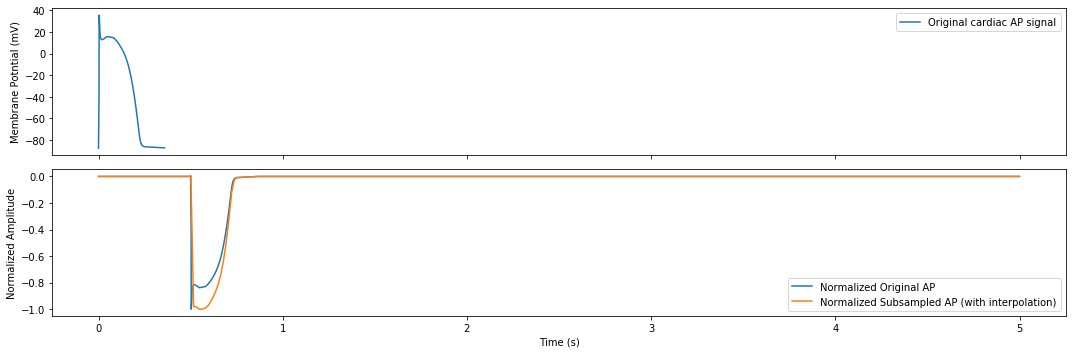

In [7]:
fig, ax = plt.subplots(2,1,figsize=[15,5],sharex=True)
ax[0].plot(AP_original[:,0],AP_original[:,1],label='Original cardiac AP signal')
ax[0].set_ylabel('Membrane Potntial (mV)')
# ax[0].set_xlabel('Time (s)')
ax[0].legend()
ax[1].plot(time_original,signal,label='Normalized Original AP')
ax[1].plot(time_sub,signal_sub,label= 'Normalized Subsampled AP (with interpolation)')
# plt.axis([-0.1,5.1,-1.1,0.1])
ax[1].set_ylabel('Normalized Amplitude')
ax[1].set_xlabel('Time (s)')
ax[1].legend()
plt.tight_layout()

In [8]:
# Power of normalized AP
Signal_Power_sub = np.sum(np.square(abs(signal_sub)),axis=0)/(n_samples)
print(Signal_Power_sub)

0.030509375019984204


## Load video with no signal (from experimental data Cell1)

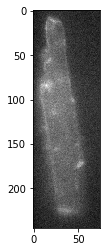

In [18]:
from skimage import io
vid0 = io.imread("../Data/Cell1/video0/vid0.tif")
vid0_mask = io.imread("../Data/Cell1/video0/cellmask.tif")
plt.imshow(vid0[0],cmap='gray')
time_vid0 = np.arange(0, vid0.shape[0])/55.78 #time vector for vid0

### Estimate illumination heterogeneities

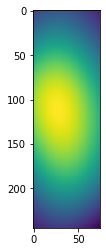

In [11]:
from skimage import filters as filt
from skimage import io
K_illumin = filt.gaussian(vid0[0],sigma=min((vid0.shape[1],vid0.shape[2]))//2)
plt.imshow(K_illumin)

### Normalize illumination

In [12]:
K_illumin2 = K_illumin*(1/np.amax(K_illumin))

### Make an inverse transformation on illumination to apply it onto video to compensate spatial variability due to illumination

In [19]:
min_K_illumin = np.amin(K_illumin2)
max_K_illumin = np.amax(K_illumin2)
delta_K_illumin = max_K_illumin - min_K_illumin

#Normalize K_illumin2
K_illumin_inv = (K_illumin2 - min_K_illumin)/(delta_K_illumin)

#Invert values
K_illumin_inv = 1 - K_illumin_inv

#Restore original values
K_illumin_inv = K_illumin_inv*(delta_K_illumin) + min_K_illumin

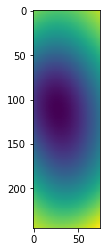

In [20]:
plt.imshow(K_illumin_inv)

### Before and after application of illumination heterogeneities correction

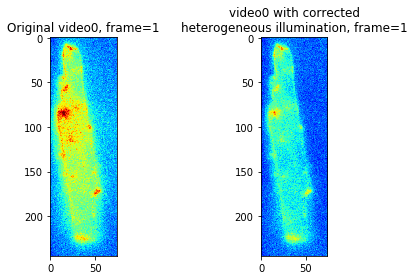

In [21]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(vid0[0],cmap='jet',vmin=3000,vmax=12000)
ax[0].set_title('Original video0, frame=1')
ax[1].imshow(K_illumin_inv*vid0[0],cmap='jet',vmin=3000,vmax=12000)
ax[1].set_title('video0 with corrected\nheterogeneous illumination, frame=1')
plt.tight_layout()

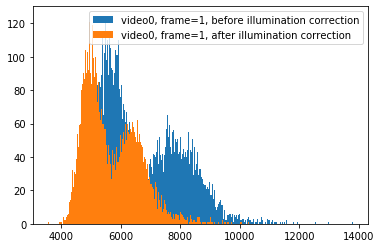

In [22]:
plt.hist(np.ravel(vid0[0]),bins=800,label='video0, frame=1, before illumination correction')
plt.hist(np.ravel(K_illumin_inv*vid0[0]),bins=800,label='video0, frame=1, after illumination correction')
plt.legend()

## Load a cell mask (scaled from experimental data Cell2)
### (to avoid confusion with Cell1 experimental data results)

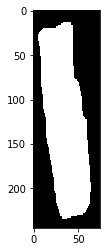

In [17]:
cell_mask = io.imread('./newcellmask.tif')
plt.imshow(cell_mask, cmap='gray')

### Get experimental data (video0) mean and standard deviation for each frame outside cell and inside cell
### These parameters will be used to generate basal fluorescence levels (from fluorescence means) 

In [23]:
vid0_illum_corr = K_illumin_inv*vid0 #Aplly illumination correction

spatial_F_mean_BG = np.mean(vid0[:,cell_mask==0],axis=1)
spatial_F_mean_CELL = np.mean(vid0[:,cell_mask>0],axis=1)

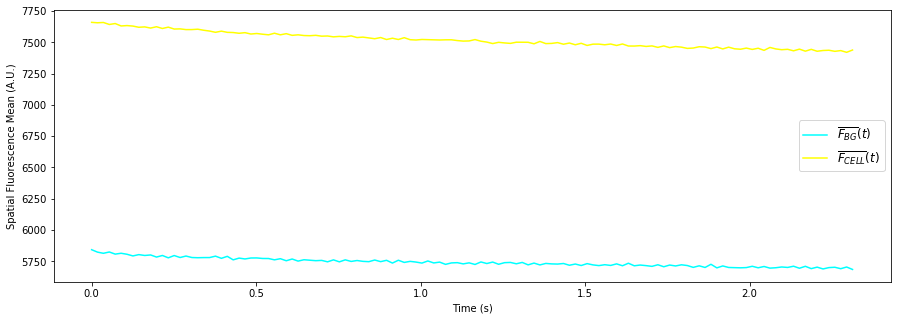

In [24]:
fig, ax = plt.subplots(1,1,figsize=[15,5])
ax.plot(time_vid0,spatial_F_mean_BG,label=r'$\overline{F_{BG}}(t)$',color='cyan')
ax.plot(time_vid0,spatial_F_mean_CELL,label=r'$\overline{F_{CELL}}(t)$',color='yellow')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Spatial Fluorescence Mean (A.U.)')
ax.legend(fontsize='large')

#### fix photobleaching

In [25]:
def monoexp_and_line(x, a, b, c, d):
    return a * np.exp(-b * x) - (c * x) + d
#Fit exponentials
def fix_photob(data,time):

    def monoexp_and_line(x, a, b, c, d):
        return a * np.exp(-b * x) - (c * x) + d
 
    from scipy.optimize import curve_fit
    photobleaching = data
    plt.figure(figsize=[15,5])
    plt.plot(time,photobleaching)
    y0 = np.mean(photobleaching[0:5])
    yf = np.mean(photobleaching[-5:])

    #LINEAR FIT
    c, d = np.polyfit(time,photobleaching,1)
    p = np.poly1d((c,d))

    plt.plot(time,p(time),'r-.',label='linearfit: a=%5.3f, b=%5.3f' % (c,d))
    res1 = photobleaching - p(time)

   
    #EXPONENTIAL AND LINE
    upper_bounds = [2*(y0-yf), -2*(np.log(y0-yf)-np.log(d-(c*yf)-c)), 2*(abs(c)), 2*yf]
    print(upper_bounds)
    popt, pcov = curve_fit(monoexp_and_line, time, photobleaching, bounds=(0, upper_bounds))

    plt.plot(time, monoexp_and_line(time, *popt), 'c-.', label='expandlinfit: a=%5.3f, b=%5.3f, c=%5.3f, d=%5.3f' % tuple(popt))
    res2 = photobleaching - monoexp_and_line(time, *popt)

    plt.legend()
    return(popt)

[251.70616977225836, 15.438588154365531, 97.41115504757322, 11394.736149068322]
[443.63593803786534, 16.054708441706296, 180.82154664080903, 14862.247710843372]


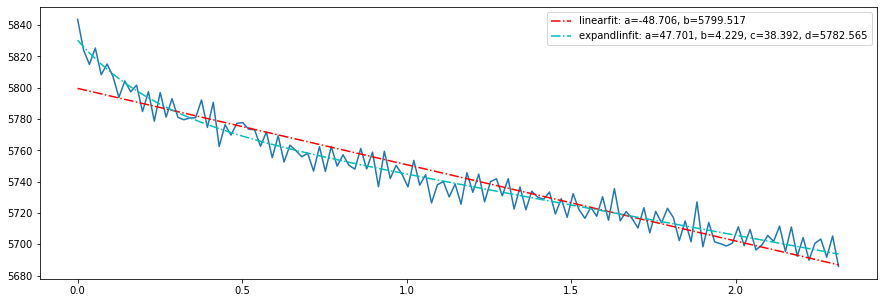

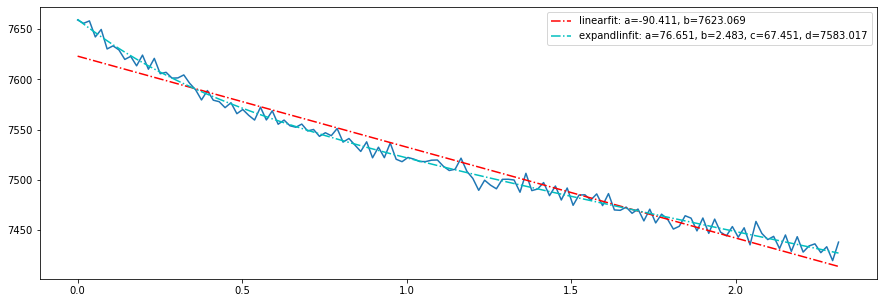

In [26]:
popt1 = fix_photob(spatial_F_mean_BG,time_vid0) #BG Fluorescence mean
popt2 = fix_photob(spatial_F_mean_CELL,time_vid0) #CELL Fluorescence mean

In [27]:
spatial_F_mean_BG -= monoexp_and_line(time_vid0, *popt1)
spatial_F_mean_BG += popt1[-1] #Adds back DC level
spatial_F_mean_CELL -= monoexp_and_line(time_vid0, *popt2)
spatial_F_mean_CELL += popt2[-1] #Adds back DC level

5782.565286058922
7583.017354616106


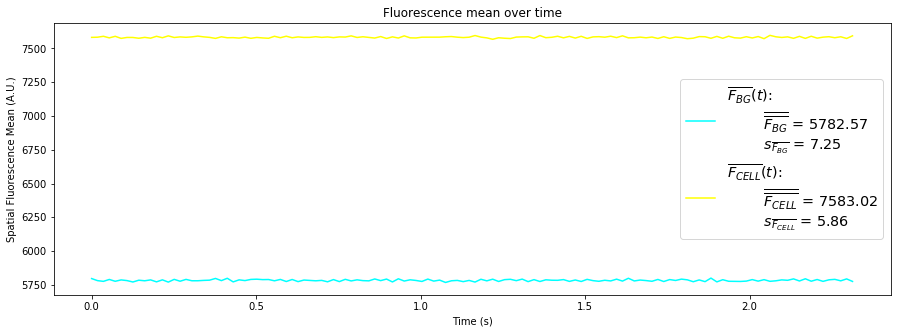

In [28]:
fig, ax = plt.subplots(1,1,figsize=[15,5])
label1 = r'$\overline{F_{BG}}(t)$:' + '\n\t' + r'$\overline{\overline{F_{BG}}}$ = ' + str(np.around(np.mean(spatial_F_mean_BG),decimals=2)) + '\n\t' + r'$s_{\overline{F_{BG}}}$ = ' + str(np.around(np.std(spatial_F_mean_BG),decimals=2))
ax.plot(time_vid0,spatial_F_mean_BG,label=label1,color='cyan')
label2 = r'$\overline{F_{CELL}}(t)$:' + '\n\t' + r'$\overline{\overline{F_{CELL}}}$ = ' + str(np.around(np.mean(spatial_F_mean_CELL),decimals=2)) + '\n\t' + r'$s_{\overline{F_{CELL}}}$ = ' + str(np.around(np.std(spatial_F_mean_CELL),decimals=2))
ax.plot(time_vid0,spatial_F_mean_CELL,label=label2,color='yellow')
ax.legend(fontsize='x-large')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Spatial Fluorescence Mean (A.U.)')
ax.set_title('Fluorescence mean over time')
print(np.mean(spatial_F_mean_BG))
print(np.mean(spatial_F_mean_CELL))

In [29]:
#These will be used to make basal fluorescence
grand_mean_F_BG = np.mean(spatial_F_mean_BG)
std_mean_F_BG = np.std(spatial_F_mean_BG)
grand_mean_F_CELL = np.mean(spatial_F_mean_CELL)
std_mean_F_CELL = np.std(spatial_F_mean_CELL)

print('BG mean variation (mean +/- std) = ',grand_mean_F_BG, ' +/- ', std_mean_F_BG)
print('CELL mean variation (mean +/- std) = ',grand_mean_F_CELL, ' +/- ', std_mean_F_CELL)

BG mean variation (mean +/- std) =  5782.565286058922  +/-  7.245599737183503
CELL mean variation (mean +/- std) =  7583.017354616106  +/-  5.856899812591744


### Generate basal fluorescence image (depicting dye concentration distribution and illumination heterogeneities)

In [30]:
BF = np.zeros_like(cell_mask,dtype=float)
illum_gain_compensation = (1, 1)
BF[cell_mask==0] = grand_mean_F_BG*K_illumin2[cell_mask==0]*illum_gain_compensation[0] #+ smooth_gain_compensation[0]*std_mean_F_BG*np.random.randn(len(cell_mask[cell_mask==0]))
BF[cell_mask>0] = grand_mean_F_CELL*K_illumin2[cell_mask>0]*illum_gain_compensation[1] #+ smooth_gain_compensation[1]*std_mean_F_CELL*np.random.randn(len(cell_mask[cell_mask>0]))

print('BF Background mean = ',np.mean(BF[cell_mask==0]))
print('BF Cell mean = ',np.mean(BF[cell_mask>0]))

illum_gain_compensation = (1.14, 1.06)
BF[cell_mask==0] = grand_mean_F_BG*K_illumin2[cell_mask==0]*illum_gain_compensation[0] #+ smooth_gain_compensation[0]*std_mean_F_BG*np.random.randn(len(cell_mask[cell_mask==0]))
BF[cell_mask>0] = grand_mean_F_CELL*K_illumin2[cell_mask>0]*illum_gain_compensation[1] #+ smooth_gain_compensation[1]*std_mean_F_CELL*np.random.randn(len(cell_mask[cell_mask>0]))
print('Background mean of video0 = ',np.mean(vid0[0,vid0_mask==0]))
print('Cell mean of video0 = ',np.mean(vid0[0,vid0_mask>0]))
print('Adjusted BF Background mean (to match video0 mean) = ',np.mean(BF[cell_mask==0]))
print('Adjusted BF Cell mean (to match video0 mean) = ',np.mean(BF[cell_mask>0]))

BF Background mean =  5078.0990759245915
BF Cell mean =  7090.266198838325
Background mean of video0 =  5751.622140364482
Cell mean of video0 =  7924.610125325723
Adjusted BF Background mean (to match video0 mean) =  5789.0329465540335
Adjusted BF Cell mean (to match video0 mean) =  7515.682170768626


### Small gaussian blur to smooth transition from cell to BG

In [31]:
from skimage import filters as filt
BF = filt.gaussian(BF,sigma=2)

In [32]:
import scipy.ndimage as sm
print(np.mean(BF[np.invert(sm.binary_dilation(cell_mask,iterations=3))>0]))
print(np.mean(BF[sm.binary_erosion(cell_mask,iterations=3)>0]))

5761.14198409647
7542.1668773059555


Text(0.5, 1.0, 'Basail Fluorescence image')

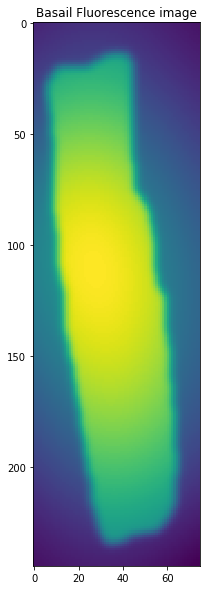

In [33]:
plt.figure(figsize=[10,10])
plt.imshow(BF)
plt.title('Basail Fluorescence image')

### Subtract a constant to equalize mean of BF with the mean of the last frames of Experimental data (Cell1, video0), which is 6304

In [34]:
print(np.mean(BF))
constant = np.mean(BF) - 6304
BF -= constant
print(np.mean(BF))

6607.694206973357
6303.999999999998


In [35]:
constant

303.6942069733568

### Generate noise variance matrix/image (depicting each pixel noise variation due to shot noise)

In [36]:
#Spatial average of the time variability (inside CELL)
spatial_mean_of_time_std_CELL = np.mean(np.std(vid0_illum_corr[:,cell_mask>0],axis=0))
print(spatial_mean_of_time_std_CELL)
#Spatial variability of the time variability (inside CELL)
spatial_std_of_time_std_CELL = np.std(np.std(vid0_illum_corr[:,cell_mask>0],axis=0))
print(spatial_std_of_time_std_CELL)

#Spatial average of the time variability (in BACKGROUND)
spatial_mean_of_time_std_BG = np.mean(np.std(vid0_illum_corr[:,cell_mask==0],axis=0))
print(spatial_mean_of_time_std_BG)
#Spatial variability of the time variability (in BACKGROUND)
spatial_std_of_time_std_BG = np.std(np.std(vid0_illum_corr[:,cell_mask==0],axis=0))
print(spatial_std_of_time_std_BG)

321.9718263868834
29.757952452412123
297.93572428181807
27.131107526314217


In [37]:
std_img = np.zeros_like(cell_mask,dtype=float)

std_img[cell_mask==0] = spatial_std_of_time_std_BG*np.random.randn(len(cell_mask[cell_mask==0])) + spatial_mean_of_time_std_BG
std_img[cell_mask>0] = spatial_std_of_time_std_CELL*np.random.randn(len(cell_mask[cell_mask>0])) + spatial_mean_of_time_std_CELL

var_img = std_img**2

Text(0.5, 1.0, 'Variance matrix/image')

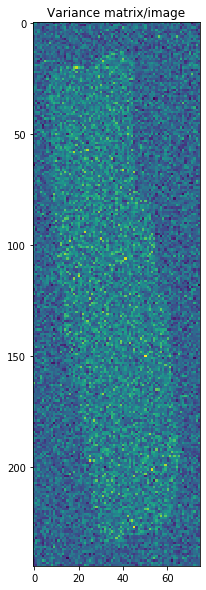

In [39]:
plt.figure(figsize=[10,10])
plt.imshow(var_img)
plt.title('Variance matrix/image')

## Generate Pure Signal video

In [40]:
normalized_signal_vid = np.repeat(signal_sub[:,np.newaxis], cell_mask.shape[1], axis=1)
normalized_signal_vid = np.repeat(normalized_signal_vid[:,np.newaxis], cell_mask.shape[0], axis=1)

#### Plot normalized_signal_vid global mean and two example pixels over time

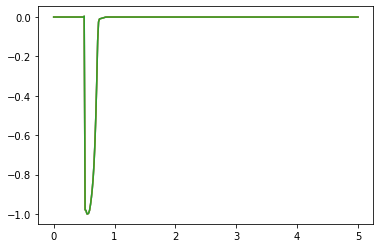

In [41]:
plt.plot(time_sub,np.mean(normalized_signal_vid,axis=(1,2)))
plt.plot(time_sub,normalized_signal_vid[:,30,30])
plt.plot(time_sub,normalized_signal_vid[:,88,30])

#### Create video with AP signal inside cell mask

In [42]:
signal_vid = np.zeros((n_samples,cell_mask.shape[0],cell_mask.shape[1]))

In [43]:
signal_vid[:,cell_mask==0] = 0#K_fluo_basal[cell_mask==0]  #dye_illum_dist[cell_mask==0]*w*F0
signal_vid[:,cell_mask>0] = BF[cell_mask>0]*normalized_signal_vid[:,cell_mask>0]

Max value from video mean= 3391.6821286903423
Signal power of px1_cell= 1403360.6759135132
Signal power of px2_cell= 1776467.6156895945
Signal power of video_mean= 350964.8293075827


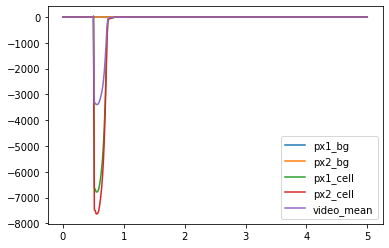

In [44]:
plt.plot(time_sub,signal_vid[:,0,0],label='px1_bg') #nosignal
plt.plot(time_sub,signal_vid[:,1,0],label='px2_bg') #signal
plt.plot(time_sub,signal_vid[:,30,30],label='px1_cell') #signal
plt.plot(time_sub,signal_vid[:,88,30], label='px2_cell') #nosignal
plt.plot(time_sub,np.mean(signal_vid,axis=(1,2)),label='video_mean')
print('Max value from video mean=',np.amax(abs(np.mean(signal_vid,axis=(1,2)))))
print('Signal power of px1_cell=',np.sum(np.square(abs(signal_vid[:,30,30])),axis=0)/(signal_vid.shape[0]))
print('Signal power of px2_cell=',np.sum(np.square(abs(signal_vid[:,88,30])),axis=0)/(signal_vid.shape[0]))
print('Signal power of video_mean=',np.sum(np.square(abs(np.mean(signal_vid,axis=(1,2)))))/(signal_vid.shape[0]))
plt.legend()

#### Generate an image whose coordinates contain respective pixel signal power

In [90]:
signal_power_img = np.zeros_like(BF)

signal_power_img[cell_mask>0] = np.sum(np.square(abs(signal_vid[:,cell_mask>0])),axis=0)/(signal_vid.shape[0])

In [91]:
print('Signal power of px1_cell=',signal_power_img[30,30])
print('Signal power of px2_cell=',signal_power_img[88,30])

Signal power of px1_cell= 1403360.6759135132
Signal power of px2_cell= 1776467.6156895945


# Here we have a video with signal inside cell modulated by BF (Basal Fluorescence)
# Now let's get ROIs means

### Divide mask with MESS and get ROIs means (from pure signal video)

In [50]:
import sys,os
    
metroidpath = os.path.abspath('../')
if metroidpath not in sys.path:
    sys.path.append(metroidpath)
items = os.listdir(metroidpath)
if 'MESS.py' not in items:
    ! jupyter nbconvert --to python ../MESS.ipynb --output-dir ../

import MESS as mes
ROIs_masks, label_ROIs, ROIs_means_signal, time   = mes.segment(cell_mask, signal_vid, 1/time_sub[1])

In [51]:
nregions = np.amax(label_ROIs).astype(int)
ncolors = nregions
from matplotlib import cm
from matplotlib.colors import ListedColormap
brg = cm.get_cmap('brg', nregions)
newcolors = np.tile((np.arange(0,ncolors))/(ncolors-1),nregions//(ncolors-1))
newcolors = newcolors[:nregions]
newcolors = brg(newcolors)
black = np.array([0, 0, 0, 1])
newcolors = np.insert(newcolors,0,black,axis=0)
newcmp = ListedColormap(newcolors)

(-0.5, 74.5, 244.5, -0.5)

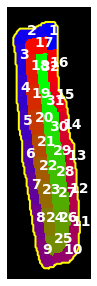

In [52]:
fig, ax = plt.subplots(figsize=[5,5],nrows=1, ncols=1)
ax.imshow(label_ROIs, cmap=newcmp)
cent_coord = np.zeros((nregions,2))
contour = mes.build_contour(cell_mask)
for j in range(nregions):
    cent_coord[j,:] = np.rint(mes.get_centroid(ROIs_masks[j,:,:]))
    ax.annotate(j+1,(cent_coord[j,0]-2,cent_coord[j,1]),xycoords='data',color='white',fontsize=14,weight='bold') 
ax.plot(contour[:,1],contour[:,0],color='yellow',lw=2)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.axis('off')

## Create Pure Noise video

Noise video shape= (340, 245, 75)


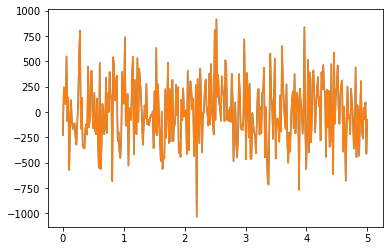

In [53]:
# Generate a sample data
np.random.seed(2280) #30lines*75columns + 30columns
noise_sample = np.random.poisson(lam=var_img[30,30],size=time_sub.shape) - var_img[30,30]
plt.plot(time_sub, noise_sample)

# Generate noise video
noise_vid = np.zeros((time_sub.shape[0],cell_mask.shape[0],cell_mask.shape[1]))
# Generate noise power image
noise_power_img = np.zeros_like(var_img)
for i in range(signal_vid.shape[1]):
    for j in range(signal_vid.shape[2]):
        #each pixel noise is independently generated
        np.random.seed((signal_vid.shape[2]*i)+j)
        #each pixel noise comes from poisson distribution with std from respective experimental pixel data
        noise_vid[:,i,j] = np.random.poisson(lam=var_img[i,j],size=time_sub.shape) - var_img[i,j] #~ zero mean noise
        #calculates each pixel noise power
        noise_power_img[i,j] = np.sum(np.square(abs(noise_vid[:,i,j])),axis=0)/(noise_vid.shape[0])
#checks if sample noise and pixel (x=30,y=30) are the same
plt.plot(time_sub, noise_vid[:,30,30])
print('Noise video shape=',noise_vid.shape)

In [54]:
print('Var of px1_cell=',var_img[30,30])
print('Noise power of px1_cell=',noise_power_img[30,30])
print('Var of px2_cell=',var_img[88,30])
print('Noise power of px2_cell=',noise_power_img[88,30])

Var of px1_cell= 98282.18363353936
Noise power of px1_cell= 97051.61305722056
Var of px2_cell= 106609.56109152109
Noise power of px2_cell= 95708.76663351605


### Divide mask with MESS and get ROIs means (from pure noise video)

In [55]:
ROIs_masks, label_ROIs, ROIs_means_noise, time   = mes.segment(cell_mask, noise_vid, 1/time_sub[1])

## Check current ROIs SNR

SNR= 2962.3787
SNR (dB)= 34.72
SNR= 3664.8542
SNR (dB)= 35.64
SNR= 3239.7018
SNR (dB)= 35.11
SNR= 4580.291
SNR (dB)= 36.61
SNR= 3729.7198
SNR (dB)= 35.72
SNR= 4032.2488
SNR (dB)= 36.06
SNR= 3507.8562
SNR (dB)= 35.45
SNR= 3798.7824
SNR (dB)= 35.8
SNR= 3134.1943
SNR (dB)= 34.96
SNR= 4012.56
SNR (dB)= 36.03
SNR= 3528.4279
SNR (dB)= 35.48
SNR= 4058.6843
SNR (dB)= 36.08
SNR= 3334.9821
SNR (dB)= 35.23
SNR= 4145.9412
SNR (dB)= 36.18
SNR= 4088.7752
SNR (dB)= 36.12
SNR= 3609.5951
SNR (dB)= 35.57
SNR= 4265.0561
SNR (dB)= 36.3
SNR= 3949.7732
SNR (dB)= 35.97
SNR= 4180.6121
SNR (dB)= 36.21
SNR= 4654.8532
SNR (dB)= 36.68
SNR= 4130.2858
SNR (dB)= 36.16
SNR= 4800.4709
SNR (dB)= 36.81
SNR= 3733.1218
SNR (dB)= 35.72
SNR= 3695.2305
SNR (dB)= 35.68
SNR= 3735.622
SNR (dB)= 35.72
SNR= 3875.8215
SNR (dB)= 35.88
SNR= 5248.1605
SNR (dB)= 37.2
SNR= 4483.8001
SNR (dB)= 36.52
SNR= 5020.5944
SNR (dB)= 37.01
SNR= 4944.3524
SNR (dB)= 36.94
SNR= 5247.6014
SNR (dB)= 37.2
SNR= 4499.8645
SNR (dB)= 36.53


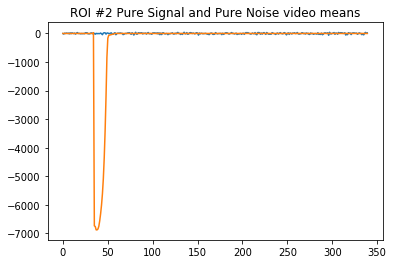

In [56]:
N = np.zeros((nregions))
P = np.zeros((nregions))
for i in range(nregions):
    P[i] = np.sum(np.square(abs(ROIs_means_signal[:,i])),axis=0)/(n_samples) #Power in each ROI for pure AP video
    N[i] = np.sum(np.square(abs(ROIs_means_noise[:,i])),axis=0)/(n_samples)
    SNR = P[i]/N[i]
    SNR_dB = 10*np.log10(SNR)
    print('SNR=',np.around(SNR,decimals=4))
    print('SNR (dB)=',np.around(SNR_dB,decimals=2))
plt.title('ROI #2 Pure Signal and Pure Noise video means')
plt.plot(ROIs_means_noise[:,2])
plt.plot(ROIs_means_signal[:,2])

### Calculate each pixel signal gain necessary to make ROI SNR ~= -1.4dB

### Calculate each pixel signal gain necessary to reach desired ROI SNR
### SNR mean and SD obtained from experimental data (Cell1 videos 1 and 2: AP signal)

#### Calculate ROIs areas in number of pixels to estimate signal averaging

In [58]:
for i in range(nregions+1):
    region_area_px = len(label_ROIs[label_ROIs==i])
#     print(region_area_px)
    region_area_perc = region_area_px/(np.size(label_ROIs))
    region_area_perc *= 100
#     print('percentage=%.2f' % region_area_perc)

In [59]:
np.random.seed(2280)
if SNR_distribution == 'uniform':
    Desired_SNR_dB_vector = np.repeat(Desired_SNR_dB,nregions)
elif SNR_distribution == 'normal':
    Desired_SNR_dB_vector = Desired_SNR_SD_dB*np.random.randn(nregions) + Desired_SNR_dB
elif SNR_distribution =='BF_modulated':
    ROIs_means_BF = np.zeros(nregions)
    for i in range(nregions):
        ROIs_means_BF[i] = np.mean(BF[label_ROIs==i+1])
    norm_ROIs_means_BF = (ROIs_means_BF - np.amin(ROIs_means_BF))/(np.amax(ROIs_means_BF) - np.amin(ROIs_means_BF))
    Desired_SNR_dB_vector = (Desired_Max_SNR_dB - (Desired_Min_SNR_dB))*norm_ROIs_means_BF + Desired_Min_SNR_dB
    
Desired_SNR = 10**(Desired_SNR_dB_vector/10)
P = np.zeros((nregions))

gain_per_px_in_ROI = np.ones_like(var_img) #Average Noise gain per pixel inside each region

for i in range(nregions):
    P[i] = np.sum(np.square(abs(ROIs_means_signal[:,i])),axis=0)/(n_samples) #Power in each ROI for pure AP video

    ROI_area_px = len(label_ROIs[label_ROIs==i+1])  #each ROI area (in number of pixels)

    gain_per_px_in_ROI[label_ROIs==i+1] = np.sqrt(((Desired_SNR[i]*noise_power_img[label_ROIs==i+1])/(ROI_area_px*signal_power_img[label_ROIs==i+1])))


In [60]:
Desired_SNR

array([0.08, 0.09, 0.22, 0.74, 1.33, 1.06, 0.56, 0.2 , 0.05, 0.05, 0.11,
       0.32, 0.62, 0.87, 0.7 , 0.28, 0.21, 0.56, 1.42, 2.14, 2.05, 1.42,
       0.75, 0.3 , 0.11, 0.26, 0.58, 1.04, 1.52, 1.85, 1.48, 0.55])

#### Print two example pixel signal power

In [61]:
print('Signal power of px1_cell=',signal_power_img[30,30])
print('Signal power of px2_cell=',signal_power_img[88,30])

Signal power of px1_cell= 1403360.6759135132
Signal power of px2_cell= 1776467.6156895945


#### Print two example pixel noise power

In [62]:
# print(noise_power_img[:,30])
print('Noise power of px1_cell=',noise_power_img[30,30])
print('Noise power of px2_cell=',noise_power_img[88,30])


Noise power of px1_cell= 97051.61305722056
Noise power of px2_cell= 95708.76663351605


#### Print two example pixel signal gain

In [63]:
# print(gain_per_px_in_ROI[:,30])
print('Gain of signal of px1_cell=',gain_per_px_in_ROI[30,30])
print('Gain of signal of px2_cell=',gain_per_px_in_ROI[88,30])


Gain of signal of px1_cell= 0.007176022378996811
Gain of signal of px2_cell= 0.016815941653786196


#### Print two example pixel snr and expected new snr after gain

In [64]:
print('snr (dB) before gain of px1_cell=',10*np.log10(signal_power_img[30,30]/noise_power_img[30,30]))
print('snr (dB) before gain of px2_cell=',10*np.log10(signal_power_img[88,30]/noise_power_img[88,30]))
print('snr (dB) after gain of px1_cell=',10*np.log10(np.power(gain_per_px_in_ROI[30,30],2)*signal_power_img[30,30]/noise_power_img[30,30]))
print('snr (dB) after gain of px2_cell=',10*np.log10(np.power(gain_per_px_in_ROI[88,30],2)*signal_power_img[88,30]/noise_power_img[88,30]))

snr (dB) before gain of px1_cell= 11.601665448131119
snr (dB) before gain of px2_cell= 12.686055752191464
snr (dB) after gain of px1_cell= -31.280658863467927
snr (dB) after gain of px2_cell= -22.799520411473736


### Apply gain to pure AP vid with necessary pixel amplitude gain to result in Desired ROI SNR

In [65]:
signal_vid2 = np.zeros((time_sub.shape[0],cell_mask.shape[0],cell_mask.shape[1]))

signal_power_img2 = np.zeros_like(var_img)

signal_vid2 = signal_vid*gain_per_px_in_ROI

signal_power_img2 = np.sum(np.square(abs(signal_vid2)),axis=0)/(signal_vid2.shape[0])

### Divide mask with MESS and get ROIs means (from adjusted pure signal video)

In [66]:
ROIs_masks, label_ROIs, ROIs_means_signal2, time   = mes.segment(cell_mask, signal_vid2, 1/time_sub[1])

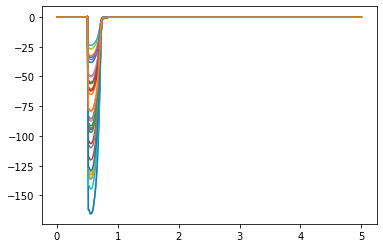

In [67]:
plt.plot(time,ROIs_means_signal2)

## Calculate ROIs adjusted signal power and adjusted SNR and plot an example ROI mean over time for adjusted pure signal and pure noise

SNR= 0.0803159009358217
SNR (dB)= -10.951984646211262
SNR= 0.0905027439509011
SNR (dB)= -10.43338253229388
SNR= 0.21493136838269977
SNR (dB)= -6.677001963217513
SNR= 0.7503784391754076
SNR (dB)= -1.247196531493411
SNR= 1.219921333733869
SNR (dB)= 0.8633182622654566
SNR= 1.0473073496230625
SNR (dB)= 0.20074151265666218
SNR= 0.5145781212373688
SNR (dB)= -2.8854868300689533
SNR= 0.20010079661484853
SNR (dB)= -6.98751182404547
SNR= 0.05520591040656217
SNR (dB)= -12.58014423728309
SNR= 0.05692062763101269
SNR (dB)= -12.447303198459629
SNR= 0.1171371282204796
SNR (dB)= -9.313054275104424
SNR= 0.3488026061525248
SNR (dB)= -4.574202788041719
SNR= 0.5297394454183837
SNR (dB)= -2.7593768745759912
SNR= 0.861136596638688
SNR (dB)= -0.6492795370180278
SNR= 0.6907917932929863
SNR (dB)= -1.606528305555657
SNR= 0.27456841678339716
SNR (dB)= -5.613494205062234
SNR= 0.22872534966560068
SNR (dB)= -6.406856998016942
SNR= 0.5541148339853362
SNR (dB)= -2.5640022336158497
SNR= 1.3392514933522006
SNR (dB)= 1.

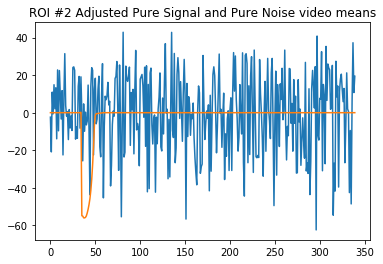

In [68]:
P2 = np.zeros_like(P)
SNR = np.zeros_like(P)
for i in range(nregions):
    P2[i] = np.sum(np.square(abs(ROIs_means_signal2[:,i])),axis=0)/(n_samples)
    SNR[i] = P2[i]/N[i]
    SNR_dB = 10*np.log10(SNR[i])
    print('SNR=',SNR[i])
    print('SNR (dB)=',SNR_dB)
plt.title('ROI #2 Adjusted Pure Signal and Pure Noise video means')
plt.plot(ROIs_means_noise[:,2])
plt.plot(ROIs_means_signal2[:,2])
print('SNR_dB mean=',np.mean(SNR_dB))

# Generate artificial video without photobleaching

In [69]:
artificial_video = np.zeros_like(noise_vid)
artificial_video += Basal_fluorescence_switch*np.repeat(BF[np.newaxis,:],len(time_sub),axis=0) #K_BF
artificial_video += Signal_switch*signal_vid2 # + K_BF*signal
artificial_video += Poisson_noise_switch*noise_vid # + Poisson Noise

artificial_video = np.around(artificial_video).astype('uint16')

In [70]:
np.mean(artificial_video)

6302.534710684274

## save video wihtout photobleaching

In [71]:
# art_vid_path = "./Output_AP_video/artificial_video_AP_nophotob.tif"
# io.imsave(art_vid_path,artificial_video.astype('uint16'),plugin='tifffile')

## Photobleaching

## Get global photobleaching parameters from experimental data (Cell1, video0)

In [72]:
#PHOTOBLEACHING (parameters got from video1 global photobleaching curve_fittings: exp and lin gave less residues than
# liner, monoexponential and doubleexponential (wildly unstable this one btw))

# But choosing better initial guess for first exponential time constant based on exp+linear fit yielded less residues 
# with double exponential without overflowing any of the parameters
a = 43.1
b = 4.6
e = 353.7
f = 0.2
d = 6302.4
# s1_end = a*np.exp(-b*5) +e*np.exp(-f*5)
# print(s1_end)

Text(0.5, 1.0, 'Global photobleaching from Cell1 video0')

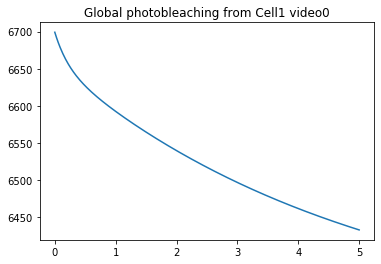

In [73]:
experimental_photob_function = a*np.exp(-b*time_sub) +e*np.exp(-f*time_sub) + d

plt.plot(time_sub,experimental_photob_function)
plt.title('Global photobleaching from Cell1 video0')

## Artificial video: AP signal + Photobleaching + Noise

In [74]:
default_photob_vid = np.repeat(experimental_photob_function[:,np.newaxis], cell_mask.shape[1], axis=1)
default_photob_vid = np.repeat(default_photob_vid[:,np.newaxis], cell_mask.shape[0], axis=1)
photob_vid_with_offset = (BF/np.amax(BF))*default_photob_vid #Default experimental photobleaching spatially modulated by BF

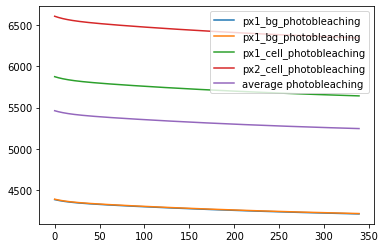

In [75]:
plt.plot(photob_vid_with_offset[:,0,0],label='px1_bg_photobleaching')
plt.plot(photob_vid_with_offset[:,1,0],label='px1_bg_photobleaching')
plt.plot(photob_vid_with_offset[:,30,30],label='px1_cell_photobleaching')
plt.plot(photob_vid_with_offset[:,88,30],label='px2_cell_photobleaching')
plt.plot(np.mean(photob_vid_with_offset,axis=(1,2)),label='average photobleaching')
plt.legend()

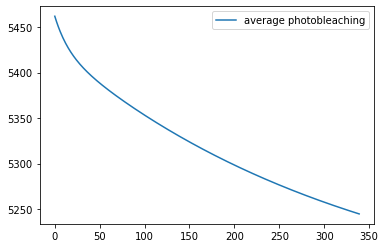

In [76]:
plt.plot(np.mean(photob_vid_with_offset,axis=(1,2)),label='average photobleaching')
plt.legend()

In [77]:
#Subtract offset to make average global photobleaching reach zero in the end of the video 
#  (some pixels will become negative in this video)
photob_vid = photob_vid_with_offset - np.mean(photob_vid_with_offset,axis=(1,2))[-1]

# Weight applied to make average global photobleaching equal to experimental data (Cell1, video0)
# Empirical 
W = 1.825
photob_vid= photob_vid*W

In [78]:
np.mean(photob_vid,axis=(1,2))[0]

396.8139903017333

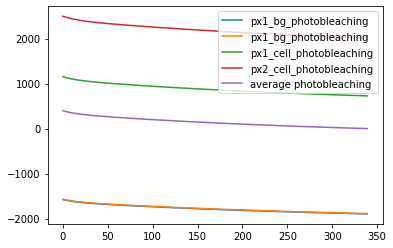

In [79]:
plt.plot(photob_vid[:,0,0],label='px1_bg_photobleaching')
plt.plot(photob_vid[:,1,0],label='px1_bg_photobleaching')
plt.plot(photob_vid[:,30,30],label='px1_cell_photobleaching')
plt.plot(photob_vid[:,88,30],label='px2_cell_photobleaching')
plt.plot(np.mean(photob_vid,axis=(1,2)),label='average photobleaching')
plt.legend()

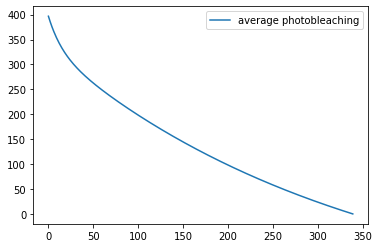

In [80]:
plt.plot(np.mean(photob_vid,axis=(1,2)),label='average photobleaching')
plt.legend()

In [81]:
artificial_video2 = np.zeros_like(noise_vid)
artificial_video2 += Basal_fluorescence_switch*np.repeat(BF[np.newaxis,:],len(time_sub),axis=0) #BF
artificial_video2 += Signal_switch*signal_vid2 # + BF*signal
artificial_video2 += Photobleaching_switch*photob_vid # + BF*photob
artificial_video2 += Poisson_noise_switch*noise_vid # + Poisson Noise

artificial_video2 = np.around(artificial_video2).astype('uint16')

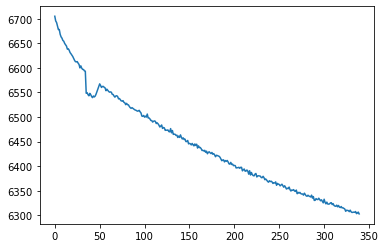

In [83]:
plt.plot(np.mean(artificial_video2,axis=(1,2)))

## Save video with photobleaching

In [84]:
art_vid_path = "./Output_AP_video/artificial_video_AP.tif"
io.imsave(art_vid_path,artificial_video2.astype('uint16'),plugin='tifffile')

# \_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_End of artificial video creation____________________

## Open Experimetnal data

In [85]:
from skimage import io
vid_cell1_AP = io.imread("../Data/Cell1/videos_AP/vid1.tif")
cell_mask1 = io.imread("../Data/Cell1/videos_AP/cellmask.tif")

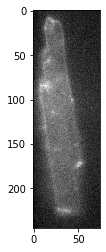

In [86]:
plt.imshow(vid_cell1_AP[0],cmap='gray')

In [87]:
# MESS on experimental data
ROIs_masks_cell1, label_ROIs_cell1, ROIs_means_cell1, time_cell1   = mes.segment(cell_mask1, vid_cell1_AP, 55.78)
# MESS ona rtificial data
ROIs_masks_artificial, label_ROIs_artificial, ROIs_means_artificial, time_artificial   = mes.segment(cell_mask, artificial_video2, fs)

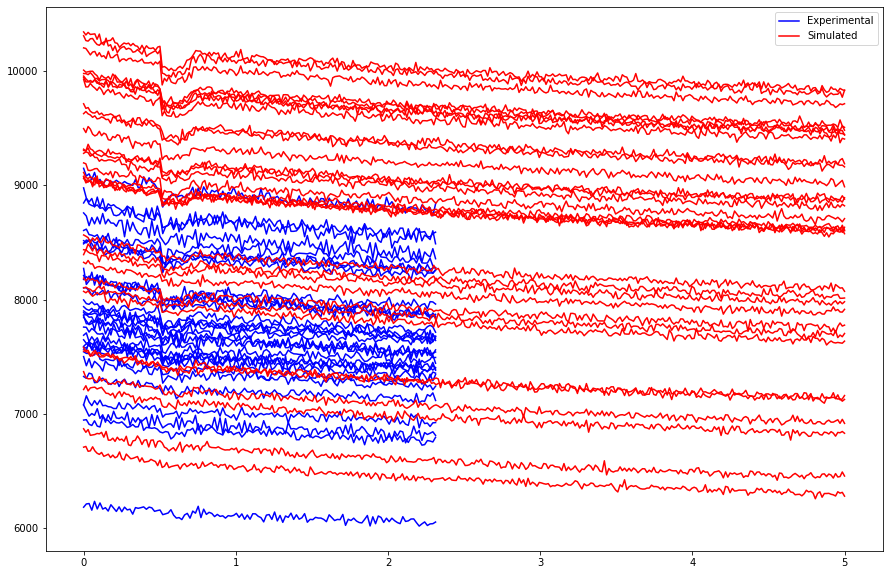

In [88]:
fig, ax = plt.subplots(1,1,figsize=[15,10])
a1 = ax.plot(time_cell1,ROIs_means_cell1,'b')
a2 = ax.plot(time_artificial,ROIs_means_artificial,'r')
ax.legend((a1[0],a2[0]),('Experimental','Simulated'))

8416.303796814422
8399.770038938344


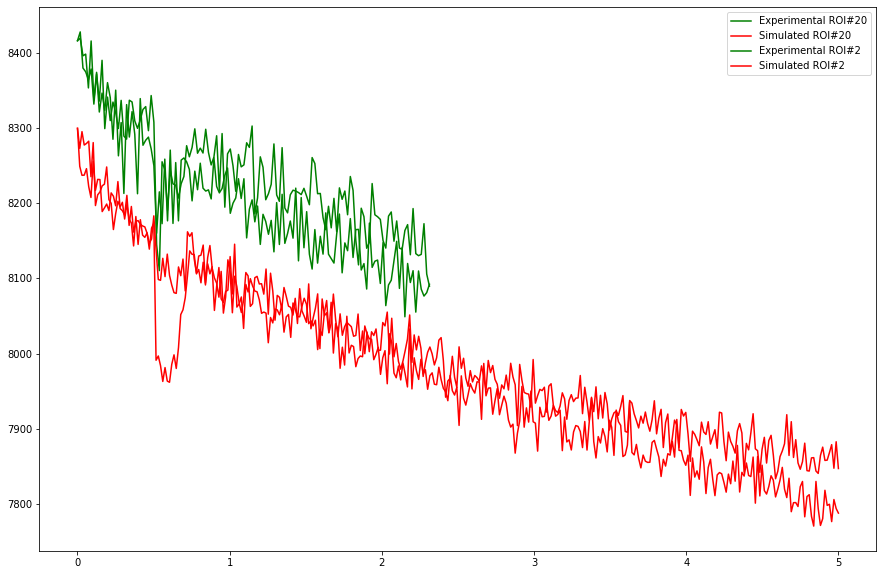

In [89]:
ROIs_means_cell1_samey0 = np.zeros_like(ROIs_means_cell1)
y0 = np.mean(ROIs_means_cell1[0][:5])
print(y0)
for i in range(nregions):
    ROIs_means_cell1_samey0[:,i] = ROIs_means_cell1[:,i] - (ROIs_means_cell1[0,i] - y0)

ROIs_means_artificial_samey0 = np.zeros_like(ROIs_means_artificial)
y0 = np.mean(ROIs_means_artificial[0][:5])
print(y0)
for i in range(nregions):
    ROIs_means_artificial_samey0[:,i] = ROIs_means_artificial[:,i] - (ROIs_means_artificial[0,i] - y0)
    
plt.figure(figsize=[15,10])
plt.plot(time_cell1,ROIs_means_cell1_samey0[:,19],'g', label = 'Experimental ROI#20')
plt.plot(time_artificial,ROIs_means_artificial_samey0[:,19]-100,'r', label = 'Simulated ROI#20')
plt.plot(time_cell1,ROIs_means_cell1_samey0[:,1],'g', label = 'Experimental ROI#2')
plt.plot(time_artificial,ROIs_means_artificial_samey0[:,1]-100,'r', label = 'Simulated ROI#2')
plt.legend()

# \_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_\_Comparsion to other methods____________________

# True outputs

### Max amplitude

In [92]:
true_max_values = np.amax(abs(ROIs_means_signal2),axis=0)
print(true_max_values)

[ 33.9   32.55  56.04  93.67 136.28 120.12  87.42  49.59  26.7   23.73
  38.2   65.06  91.47 106.37  94.87  60.77  50.2   85.48 135.3  165.58
 165.3  132.67  97.03  62.16  35.8   54.91  78.78 109.84 130.37 144.58
 128.9   79.14]


In [93]:
true_max_values = abs(ROIs_means_signal2[max_idx_sub])
print(true_max_values)

[ 33.9   32.55  56.04  93.67 136.28 120.12  87.42  49.59  26.7   23.73
  38.2   65.06  91.47 106.37  94.87  60.77  50.2   85.48 135.3  165.58
 165.3  132.67  97.03  62.16  35.8   54.91  78.78 109.84 130.37 144.58
 128.9   79.14]


### True waveform

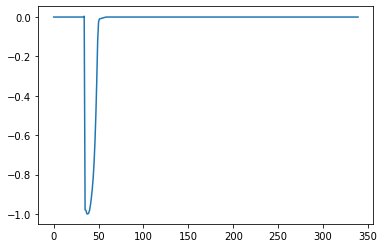

In [94]:
plt.plot(signal_sub)

### RMSE is zero (there is no noise in pure signal)

# Blank Subtraction (BkS)

## Generate Blank Video

### Create Another Pure Noise video

Noise video shape= (340, 245, 75)


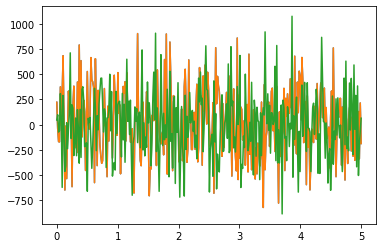

In [95]:
# Generate a sample data
np.random.seed(18375) #245lines*75columns
noise_sample2 = np.random.poisson(lam=var_img[0,0],size=time_sub.shape) - var_img[0,0]
plt.plot(time_sub, noise_sample2)

# Generate noise video
noise_vid2 = np.zeros((time_sub.shape[0],cell_mask.shape[0],cell_mask.shape[1]))
# Generate noise power image
noise_power_img2 = np.zeros_like(var_img)
for i in range(vid0.shape[1]):
    for j in range(vid0.shape[2]):
        #each pixel noise is independently generated
        np.random.seed((vid0.shape[2]*i)+j+(vid0.shape[1]*vid0.shape[2]))
        #each pixel noise comes from poisson distribution with std from respective experimental pixel data
        noise_vid2[:,i,j] = np.random.poisson(lam=var_img[i,j],size=time_sub.shape) - var_img[i,j] #~ zero mean noise
        #calculates each pixel noise power
        noise_power_img2[i,j] = np.sum(np.square(abs(noise_vid2[:,i,j])),axis=0)/(noise_vid2.shape[0])
#checks if sample noise and pixel (x=30,y=30) are the same
plt.plot(time_sub, noise_vid2[:,0,0])
plt.plot(time_sub, noise_vid[:,0,0])
print('Noise video shape=',noise_vid2.shape)

In [96]:
print('Var of px1_cell=',var_img[0,0])
print('Noise power of px1_cell=',noise_power_img2[0,0])

Var of px1_cell= 113525.57230645166
Noise power of px1_cell= 107886.1904346722


### Create blank video (no signal; noise here is independent from noise of artificial video with signal; photobleaching and basal fluorescence 0.3% higher to represent a slow drift in photobleaching from trial to trial)

In [97]:
photobleaching_drift_percent /= 100
photobleaching_drift_percent += 1
print(photobleaching_drift_percent)

1.003


In [98]:
Basal_fluorescence_switch = True
Photobleaching_switch = True
Signal_switch = False
Poisson_noise_switch = True

pure_basal_fluo_vid = np.repeat(BF[np.newaxis,:],len(time_sub),axis=0) #static fluorescence signal

blank_video = np.zeros_like(noise_vid)
blank_video += photobleaching_drift_percent*Basal_fluorescence_switch*pure_basal_fluo_vid + photobleaching_drift_percent*Photobleaching_switch*photob_vid + \
                Signal_switch*signal_vid2 + Poisson_noise_switch*noise_vid2

blank_video = np.around(blank_video).astype('uint16')

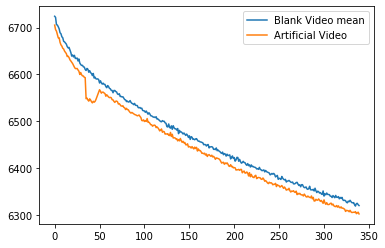

In [99]:
plt.plot(np.mean(blank_video,axis=(1,2)),label='Blank Video mean')
plt.plot(np.mean(artificial_video2,axis=(1,2)),label='Artificial Video')
plt.legend()

### Blank Video Subtraction (BkS)

In [100]:
corrected_signal_video = artificial_video2/np.mean(artificial_video2[:i0_5_sub-1],axis=0)
corrected_blank_video = blank_video/np.mean(blank_video[:i0_5_sub-1],axis=0)
BkS_video = (corrected_signal_video - corrected_blank_video)*np.mean(artificial_video2[:i0_5_sub-1],axis=0)

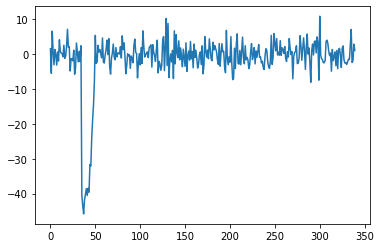

In [101]:
plt.plot(np.mean(BkS_video,axis=(1,2)))

In [102]:
ROIs_masks_artificial, label_ROIs_artificial, ROIs_means_BkS, time_artificial   = mes.segment(cell_mask, BkS_video, 1/time_sub[1])

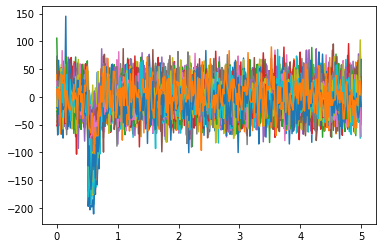

In [103]:
plt.plot(time_artificial,ROIs_means_BkS)

# Performance outputs

### Relative Max Amplitude Error

In [104]:
BkS_meanbaseline = np.median(np.concatenate((ROIs_means_BkS[0:i0_5_sub],ROIs_means_BkS[i0_8_sub:])),axis=0)
print(BkS_meanbaseline)
BkS_no_offset = ROIs_means_BkS - BkS_meanbaseline

[-6.25  5.04 -6.97 -1.49  5.31 -5.66  6.64 -3.11  0.79  2.45  0.55 -7.41
  8.82  0.21 -1.18 -3.85  2.79  0.77 -0.41 -3.33 -2.38 -1.72 -2.29  4.94
  3.32 -1.74  1.3   5.58 -6.19 -0.12 -8.49  4.53]


In [105]:
BkS_max_values = -(ROIs_means_BkS[max_idx_sub] - BkS_meanbaseline)
print(BkS_max_values)

[ 19.32  19.87  57.2  117.09 133.44 122.64 105.62  72.57   7.65  51.06
  34.78  86.5  104.11 111.98  31.56  66.2   17.12  42.79 177.49 189.79
 194.1  135.79  71.13  57.84  44.45  62.02  71.49 106.1  128.35  75.65
 158.51  69.33]


In [106]:
Rel_error_BkS = ((BkS_max_values-true_max_values)/true_max_values)*100 
print(Rel_error_BkS)

[-43.   -38.96   2.07  25.    -2.09   2.09  20.82  46.34 -71.35 115.12
  -8.95  32.95  13.82   5.27 -66.73   8.93 -65.9  -49.94  31.18  14.62
  17.42   2.35 -26.69  -6.96  24.15  12.95  -9.26  -3.41  -1.55 -47.67
  22.96 -12.39]


### Pearson Correlation Coefficient

In [108]:
corrBks = np.zeros((nregions,))
for i in range(nregions):
    matrix = np.corrcoef(signal_sub[i0_5_sub-1:i0_8_sub],ROIs_means_BkS[i0_5_sub-1:i0_8_sub,i],rowvar=False)
    corrBks[i] = abs(matrix[0,1])
print(corrBks)

[0.58 0.6  0.76 0.81 0.95 0.79 0.69 0.74 0.39 0.58 0.6  0.72 0.85 0.83
 0.83 0.74 0.67 0.84 0.92 0.95 0.95 0.89 0.82 0.69 0.58 0.49 0.78 0.92
 0.93 0.91 0.89 0.85]


### RMSE (Root-Mean-Squared Error)

In [110]:
RMSE_BkS = (np.sqrt(np.sum((BkS_no_offset - ROIs_means_signal2)**2,axis=0)/n_samples))
print(RMSE_BkS)

[29.28 26.8  27.88 27.51 31.18 30.55 30.   27.28 29.69 24.21 26.6  26.65
 29.04 30.54 27.99 28.36 27.34 26.87 28.74 28.19 30.3  26.5  29.51 29.24
 26.23 27.42 24.03 26.88 26.05 26.1  25.44 26.91]


# Blank Subtraction + detrending (BkSD)

In [112]:
from scipy import signal as sig
ROIs_means_BkSD = sig.detrend(ROIs_means_BkS,axis=0)

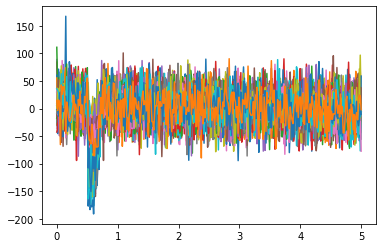

In [113]:
plt.plot(time_artificial,ROIs_means_BkSD)

# Performance outputs

### Relative Max Amplitude Error

In [114]:
BkSD_meanbaseline = np.median(np.concatenate((ROIs_means_BkSD[0:i0_5_sub],ROIs_means_BkSD[i0_8_sub:])),axis=0)
print(BkSD_meanbaseline)
BkSD_no_offset = ROIs_means_BkSD - BkSD_meanbaseline

[ 0.19  1.76  2.16  3.52  2.69  2.86  2.33  0.04 -1.64  1.56  1.81  0.6
  2.51  3.56  2.71  0.12  1.32  3.48  5.03  3.41  5.25  4.28  2.31  2.8
  1.56  2.15  2.66  4.06  2.4   5.66  3.21  3.12]


In [115]:
BkSD_max_values = -(ROIs_means_BkSD[max_idx_sub] - BkSD_meanbaseline)
print(BkSD_max_values)

[ 17.33  15.76  56.95 109.32 118.19 114.85  98.85  72.94   4.38  47.7
  31.33  84.47  94.5  107.    29.39  64.95  12.31  38.02 166.57 179.21
 181.91 127.9   67.62  48.88  41.73  60.42  65.97  99.07 119.72  65.73
 153.84  67.32]


In [116]:
Rel_error_BkSD = ((BkSD_max_values-true_max_values)/true_max_values)*100 
print(Rel_error_BkSD)

[-48.89 -51.57   1.62  16.71 -13.28  -4.39  13.07  47.07 -83.61 100.98
 -18.    29.84   3.31   0.59 -69.02   6.87 -75.47 -55.52  23.11   8.23
  10.05  -3.59 -30.31 -21.36  16.55  10.04 -16.26  -9.81  -8.17 -54.54
  19.35 -14.93]


### Pearson Correlation Coefficient

In [118]:
corrBksD = np.zeros((nregions,))
for i in range(nregions):
    matrix = np.corrcoef(signal_sub[i0_5_sub-1:i0_8_sub],ROIs_means_BkSD[i0_5_sub-1:i0_8_sub,i],rowvar=False)
    corrBksD[i] = abs(matrix[0,1])
print(corrBksD)

[0.58 0.6  0.76 0.81 0.95 0.79 0.69 0.74 0.39 0.57 0.6  0.72 0.85 0.83
 0.83 0.74 0.67 0.84 0.92 0.95 0.95 0.89 0.82 0.69 0.58 0.49 0.78 0.91
 0.93 0.91 0.89 0.85]


### RMSE (Root-Mean-Squared Error)

In [120]:
RMSE_BkSD = (np.sqrt(np.sum((BkSD_no_offset - ROIs_means_signal2)**2,axis=0)/n_samples))
print(RMSE_BkSD)

[29.32 26.79 27.94 27.74 31.74 31.05 30.27 27.26 29.74 24.17 26.64 26.77
 29.28 30.9  28.16 28.43 27.42 27.15 29.32 29.26 31.19 27.19 29.79 29.16
 26.24 27.51 24.29 27.33 26.76 26.91 25.99 27.09]


# Averaging over 10 trials

In [122]:
def new_noise_vid(n,cell_mask,time_sub,var_img):
    # Generate noise video
    noise_vid2 = np.zeros((time_sub.shape[0],cell_mask.shape[0],cell_mask.shape[1]))
    # Generate noise power image
    noise_power_img2 = np.zeros_like(var_img)
    for i in range(cell_mask.shape[0]):
        for j in range(cell_mask.shape[1]):
            #each pixel noise is independently generated
            np.random.seed((cell_mask.shape[1]*i) + j + n*(cell_mask.shape[0]*cell_mask.shape[1]))
            #each pixel noise comes from poisson distribution with std from respective experimental pixel data
            noise_vid2[:,i,j] = np.random.poisson(lam=var_img[i,j],size=time_sub.shape) - var_img[i,j] #~ zero mean noise
            #calculates each pixel noise power
            noise_power_img2[i,j] = np.sum(np.square(abs(noise_vid2[:,i,j])),axis=0)/(noise_vid2.shape[0])
    return(noise_vid2,noise_power_img2)

In [123]:
avg_new_vid10_stack = np.zeros((10,artificial_video2.shape[0],artificial_video2.shape[1],artificial_video2.shape[2]),dtype='uint16')

In [124]:
Basal_fluorescence_switch = True
Photobleaching_switch = True
Signal_switch = True
Poisson_noise_switch = True

for i in range(10):
    new_vid = np.zeros_like(artificial_video2,dtype='float')
    noise_vid3, noise_power_img2 = new_noise_vid(i+1,cell_mask,time_sub,var_img)
    print(i)
    new_vid += photobleaching_drift_percent*Basal_fluorescence_switch*pure_basal_fluo_vid + photobleaching_drift_percent*Photobleaching_switch*photob_vid + \
                Signal_switch*signal_vid2 + Poisson_noise_switch*noise_vid3
    new_vid = np.around(new_vid).astype('uint16')
    
    avg_new_vid10_stack[i] = new_vid
avg_new_vid10 = np.mean(avg_new_vid10_stack,axis=0)

0
1
2
3
4
5
6
7
8
9


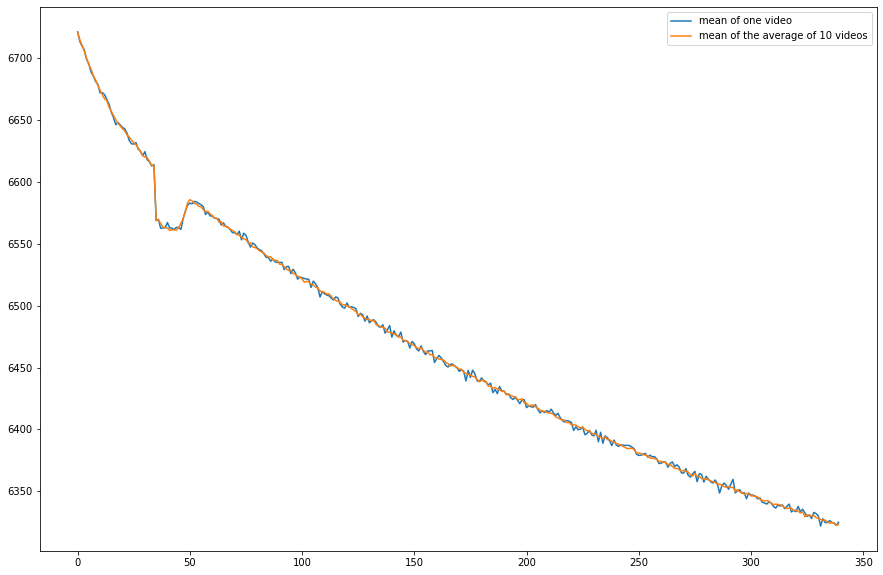

In [125]:
plt.figure(figsize=[15,10])
plt.plot(np.mean(new_vid,axis=(1,2)),label='mean of one video')
plt.plot(np.mean(avg_new_vid10,axis=(1,2)),label='mean of the average of 10 videos')
plt.legend()

In [126]:
ROIs_masks_artificial, label_ROIs_artificial, ROIs_means_avg10, time_artificial   = mes.segment(cell_mask, avg_new_vid10, 1/time_sub[1])
import Remove_Photobleaching as rpb
transitory = True
t_sig_onset = 0.5
t_sig_end = 0.8
ROIs_means_avg10_corrected, inactive_msk,t_sig_onset,t_sig_end  = rpb.photob_remove(avg_new_vid10,time_sub, cell_mask,ROIs_means_avg10,transitory,t_sig_onset,t_sig_end)

# Performance outputs

### Check Noise reduction and SNR increase

In [127]:
N_avg10 = np.zeros_like(N)
active_mask = np.zeros_like(time_sub,dtype=bool)
active_mask[i0_5_sub:i0_8_sub] = True
inactive_mask = np.invert(active_mask)

for i in range(len(N)):
    N_avg10[i] = np.sum(np.square(abs(ROIs_means_avg10_corrected[inactive_mask,i])),axis=0)/(ROIs_means_avg10_corrected[inactive_mask,:].shape[0])

In [128]:
SNR_avg10 = P2/N_avg10
print(np.mean(SNR_avg10/SNR))

7.737731403869855


### Relative Max Amplitude Error

In [129]:
avg10_meanbaseline = np.median(np.concatenate((ROIs_means_avg10_corrected[0:i0_5_sub],ROIs_means_avg10_corrected[i0_8_sub:])),axis=0)
print(avg10_meanbaseline)
avg10_no_offset = ROIs_means_avg10_corrected - avg10_meanbaseline

[-2.84e-01  4.77e-02 -4.81e-01 -1.64e-01 -9.36e-02 -1.10e-01  7.08e-02
  2.15e-01  1.02e-01  1.82e-01  4.24e-01 -3.04e-01 -1.71e-01 -1.39e-01
  8.44e-02 -7.91e-02 -1.16e-07 -1.11e-01 -1.85e-01 -1.70e-01 -1.93e-01
 -2.53e-01 -2.92e-01 -5.17e-01  2.64e-02 -1.32e-01 -3.63e-01 -1.39e-01
 -4.27e-01 -2.85e-01 -6.85e-01 -3.32e-01]


In [130]:
avg10_max_values = -(ROIs_means_avg10_corrected[max_idx_sub] - avg10_meanbaseline)
print(avg10_max_values)

[ 38.75  38.29  59.77 101.51 145.17 125.86  97.87  57.44  47.49  27.99
  49.61  81.54 115.46 114.07 121.06  75.21  69.57  88.25 141.66 169.26
 164.37 136.4  110.61  69.57  44.51  68.24  84.33 119.7  141.57 156.95
 140.33  97.49]


In [132]:
Rel_error_avg10 = ((avg10_max_values-true_max_values)/true_max_values)*100 
print(Rel_error_avg10)

[14.29 17.64  6.64  8.37  6.52  4.78 11.95 15.82 77.87 17.95 29.86 25.33
 26.22  7.23 27.6  23.76 38.57  3.24  4.7   2.22 -0.56  2.81 14.   11.91
 24.33 24.28  7.04  8.98  8.59  8.56  8.86 23.19]


### Pearson Correlation Coefficient

In [135]:
corr_avg10 = np.zeros((nregions,))
for i in range(nregions):
    matrix = np.corrcoef(signal_sub[i0_5_sub-1:i0_8_sub],ROIs_means_avg10_corrected[i0_5_sub-1:i0_8_sub,i],rowvar=False)
    corr_avg10[i] = abs(matrix[0,1])
print(corr_avg10)

[0.95 0.93 0.93 0.99 0.99 0.99 0.98 0.98 0.94 0.87 0.93 0.98 0.97 0.99
 0.98 0.97 0.97 0.98 1.   1.   1.   0.99 0.99 0.98 0.95 0.98 0.98 0.99
 1.   1.   1.   0.99]


### RMSE (Root-Mean-Squared Error)

In [137]:
RMSE_avg10 = (np.sqrt(np.sum((avg10_no_offset - ROIs_means_signal2)**2,axis=0)/n_samples))
print(RMSE_avg10)

[7.02 6.84 7.8  6.86 7.6  7.26 7.64 7.56 7.2  6.89 7.48 7.24 7.6  6.93
 7.64 7.81 7.47 7.74 7.17 7.32 7.76 7.64 7.3  6.84 7.43 7.46 7.05 7.08
 7.26 6.92 7.49 7.13]


# Averaging over n trials

In [139]:
def new_noise_vid(n,cell_mask,time_sub,var_img):
    # Generate noise video
    noise_vid2 = np.zeros((time_sub.shape[0],cell_mask.shape[0],cell_mask.shape[1]))
    # Generate noise power image
    noise_power_img2 = np.zeros_like(var_img)
    for i in range(cell_mask.shape[0]):
        for j in range(cell_mask.shape[1]):
            #each pixel noise is independently generated
            np.random.seed((cell_mask.shape[1]*i) + j + n*(cell_mask.shape[0]*cell_mask.shape[1]))
            #each pixel noise comes from poisson distribution with std from respective experimental pixel data
            noise_vid2[:,i,j] = np.random.poisson(lam=var_img[i,j],size=time_sub.shape) - var_img[i,j] #~ zero mean noise
            #calculates each pixel noise power
            noise_power_img2[i,j] = np.sum(np.square(abs(noise_vid2[:,i,j])),axis=0)/(noise_vid2.shape[0])
    return(noise_vid2,noise_power_img2)

In [141]:
avg_new_vid400_stack = np.zeros((400,artificial_video2.shape[0],artificial_video2.shape[1],artificial_video2.shape[2]),dtype='uint16')

In [142]:
Basal_fluorescence_switch = True
Photobleaching_switch = True
Signal_switch = True
Poisson_noise_switch = True
for i in range(400):
    new_vid = np.zeros_like(artificial_video2,dtype='float')
    noise_vid3, noise_power_img2 = new_noise_vid(i+1,cell_mask,time_sub,var_img)
    print(i)
    new_vid += photobleaching_drift_percent*Basal_fluorescence_switch*pure_basal_fluo_vid + photobleaching_drift_percent*Photobleaching_switch*photob_vid + \
                Signal_switch*signal_vid2 + Poisson_noise_switch*noise_vid3
    new_vid = np.around(new_vid).astype('uint16')
    
    avg_new_vid400_stack[i] = new_vid
avg_new_vids = np.mean(avg_new_vid400_stack,axis=0)

del avg_new_vid400_stack

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [143]:
ROIs_masks_artificial, label_ROIs_artificial, ROIs_means_avgn, time_artificial   = mes.segment(cell_mask, avg_new_vids, 1/time_sub[1])
import Remove_Photobleaching as rpb
transitory = True
t_sig_onset = 0.5
t_sig_end = 0.8
ROIs_means_avgn_corrected, inactive_msk,t_sig_onset,t_sig_end  = rpb.photob_remove(avg_new_vids,time_sub, cell_mask,ROIs_means_avgn,transitory,t_sig_onset,t_sig_end)

# Performance outputs

### Check Noise reduction and SNR increase

In [144]:
N_avg400 = np.zeros_like(N)
active_mask = np.zeros_like(time_sub,dtype=bool)
active_mask[i0_5_sub:i0_8_sub] = True
inactive_mask = np.invert(active_mask)

for i in range(len(N)):
    N_avg400[i] = np.sum(np.square(abs(ROIs_means_avgn_corrected[inactive_mask,i])),axis=0)/(ROIs_means_avgn_corrected[inactive_mask,:].shape[0])

In [145]:
SNR_avg400 = P2/N_avg400
print(np.mean(SNR_avg10/SNR))
print(np.mean(SNR_avg400/SNR))

7.737731403869855
29.062220047845717


### Relative Max Amplitude Error

In [146]:
avgn_meanbaseline = np.median(np.concatenate((ROIs_means_avgn_corrected[0:i0_5_sub],ROIs_means_avgn_corrected[i0_8_sub:])),axis=0)
print(avgn_meanbaseline)
avgn_no_offset = ROIs_means_avgn_corrected - avgn_meanbaseline

[-2.23e-01 -1.40e-01 -1.34e-01 -1.92e-01 -2.88e-01 -3.61e-01 -8.72e-02
 -1.25e-01 -4.09e-02 -1.92e-08 -4.63e-08 -1.75e-01 -2.72e-01 -1.89e-01
 -2.64e-01 -2.36e-01 -6.55e-02 -2.21e-01 -1.26e-02  4.96e-03 -2.42e-01
 -3.76e-01 -9.47e-02 -2.23e-01 -1.19e-01 -4.90e-08 -5.61e-08 -5.32e-02
 -2.02e-01 -1.72e-02 -2.14e-01 -2.90e-01]


In [147]:
avgn_max_values = -(ROIs_means_avgn_corrected[max_idx_sub] - avgn_meanbaseline)
print(avgn_max_values)

[ 42.09  39.9   63.66 102.58 144.58 129.29  97.04  59.65  34.06  29.57
  46.21  73.72 102.95 114.98 103.4   67.73  57.68  93.14 143.21 175.15
 173.73 142.67 105.94  69.63  43.82  64.6   86.76 118.78 139.36 154.04
 138.19  89.43]


In [148]:
Rel_error_avgn = ((avgn_max_values-true_max_values)/true_max_values)*100 
print(Rel_error_avgn)

[24.15 22.59 13.58  9.51  6.09  7.64 11.   20.28 27.59 24.59 20.96 13.31
 12.55  8.09  8.99 11.46 14.9   8.96  5.84  5.78  5.1   7.54  9.18 12.01
 22.38 17.66 10.12  8.14  6.89  6.54  7.21 13.01]


### Pearson Correlation Coefficient

In [149]:
corr_avgn = np.zeros((nregions,))
for i in range(nregions):
    matrix = np.corrcoef(signal_sub[i0_5_sub-1:i0_8_sub],ROIs_means_avgn_corrected[i0_5_sub-1:i0_8_sub,i],rowvar=False)
    corr_avgn[i] = abs(matrix[0,1])
print(corr_avgn)

[1.   0.99 1.   1.   1.   1.   1.   1.   1.   0.99 1.   1.   1.   1.
 1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 1.   1.   1.   1.  ]


### RMSE (Root-Mean-Squared Error)

In [150]:
RMSE_avgn = (np.sqrt(np.sum((avgn_no_offset - ROIs_means_signal2)**2,axis=0)/n_samples))
print(RMSE_avgn)

[3.63 3.7  3.89 4.08 4.16 4.16 4.02 3.84 3.61 3.46 3.74 3.9  4.17 4.1
 4.11 3.84 3.8  4.09 4.19 4.32 4.06 4.22 4.07 3.84 3.76 3.87 3.94 4.05
 4.19 4.31 4.28 4.07]


# Extracted outputs with METROID (default params)

In [151]:
import sys,os
if metroidpath not in sys.path:
    sys.path.append(metroidpath)
import METROID as metroid

path = "./Output_AP_video"
fr = [fs]
transitory = True

stack_ROIs_AP, label_ROIs_AP, ROIs_means_filtered_AP_default, time_AP, \
ROIs_means_AP, ROIs_means_corrected_AP,  \
mask_list_AP, components_AP, selected_source_idx_AP, \
t_sig_prop_AP, SNR_dB_AP = metroid.metroid(path, fr, transitory)

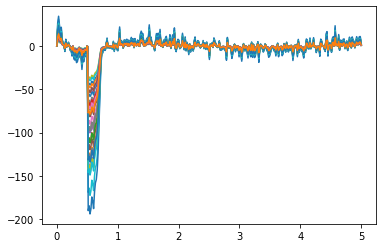

In [152]:
plt.plot(time_AP,ROIs_means_filtered_AP_default)

# Performance outputs

### Relative Max Amplitude Error

In [153]:
metroid_default_meanbaseline = np.median(np.concatenate((ROIs_means_filtered_AP_default[0:i0_5_sub],ROIs_means_filtered_AP_default[i0_8_sub:])),axis=0)
print(metroid_default_meanbaseline)
metroid_default_no_offset = ROIs_means_filtered_AP_default - metroid_default_meanbaseline

[0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.  ]


In [154]:
metroid_default_max_values = -(ROIs_means_filtered_AP_default[max_idx_sub] - metroid_default_meanbaseline)
print(metroid_default_max_values)

[ 43.83  46.99  71.81  96.54 138.8  116.24  87.7   63.88  36.47  39.05
  56.68  69.53  96.6  108.2   97.45  79.26  52.17  94.83 140.05 167.4
 188.26 126.06 108.6   66.95  52.14  52.07  70.93 127.41 140.89 144.66
 130.2   76.48]


In [155]:
Rel_error_metroid_default = ((metroid_default_max_values-true_max_values)/true_max_values)*100 
print(Rel_error_metroid_default)

[ 2.93e+01  4.44e+01  2.81e+01  3.06e+00  1.84e+00 -3.23e+00  3.16e-01
  2.88e+01  3.66e+01  6.45e+01  4.84e+01  6.88e+00  5.61e+00  1.72e+00
  2.72e+00  3.04e+01  3.92e+00  1.09e+01  3.51e+00  1.10e+00  1.39e+01
 -4.98e+00  1.19e+01  7.69e+00  4.56e+01 -5.16e+00 -9.96e+00  1.60e+01
  8.07e+00  5.63e-02  1.01e+00 -3.36e+00]


### Pearson Correlation Coefficient

In [156]:
corr_metroid_default = np.zeros((nregions,))
for i in range(nregions):
    matrix = np.corrcoef(signal_sub[i0_5_sub-1:i0_8_sub],ROIs_means_filtered_AP_default[i0_5_sub-1:i0_8_sub,i],rowvar=False)
    corr_metroid_default[i] = abs(matrix[0,1])
print(corr_metroid_default)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


### RMSE (Root-Mean-Squared Error)

In [157]:
RMSE_metroid_default = (np.sqrt(np.sum((metroid_default_no_offset - ROIs_means_signal2)**2,axis=0)/n_samples))
print(RMSE_metroid_default)

[2.6  3.26 4.2  4.32 6.18 5.22 3.9  3.77 2.35 3.18 4.08 3.18 4.38 4.82
 4.35 4.76 2.34 4.51 6.28 7.45 9.26 5.73 5.22 3.09 3.66 2.37 3.45 6.42
 6.52 6.43 5.79 3.43]


# Extracted outputs with METROID (ICA optimized parameters)

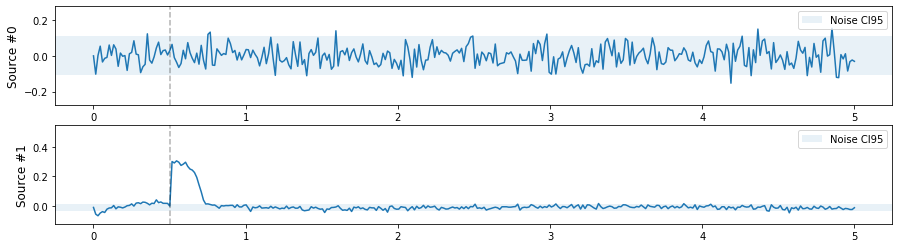

Enter one or more sources number (separate numbers by "," if number of sources > 1): 1


In [158]:
transitory = True
t_sig_onset = 0.5
t_sig_end = 0.8
n_comp = 2
method = 'ICA'
autoselect = 'manual'

stack_ROIs_AP, label_ROIs_AP, ROIs_means_filtered_AP_optimized, time_AP, \
ROIs_means_AP, ROIs_means_corrected_AP, \
mask_list_AP, components_AP, selected_source_idx_AP, \
t_sig_prop_AP, SNR_dB_AP = metroid.metroid(path, fr, transitory,16,16, t_sig_onset,t_sig_end,method,n_comp,'dmey',autoselect)

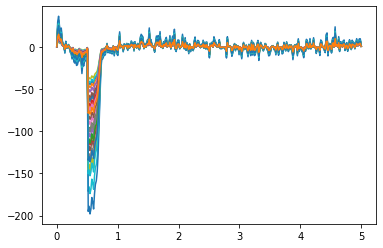

In [159]:
plt.plot(time_AP,ROIs_means_filtered_AP_optimized)

# Performance outputs

### Relative Max Amplitude Error

In [160]:
metroid_optimized_meanbaseline = np.median(np.concatenate((ROIs_means_filtered_AP_optimized[0:i0_5_sub],ROIs_means_filtered_AP_optimized[i0_8_sub:])),axis=0)
print(metroid_optimized_meanbaseline)
metroid_optimized_no_offset = ROIs_means_filtered_AP_optimized - metroid_optimized_meanbaseline

[-0.05 -0.05 -0.09 -0.11 -0.17 -0.14 -0.1  -0.07 -0.04 -0.05 -0.07 -0.08
 -0.11 -0.13 -0.12 -0.1  -0.06 -0.11 -0.16 -0.2  -0.22 -0.15 -0.13 -0.08
 -0.06 -0.07 -0.08 -0.15 -0.17 -0.17 -0.15 -0.09]


In [161]:
metroid_optimized_max_values = -(ROIs_means_filtered_AP_optimized[max_idx_sub] - metroid_optimized_meanbaseline)
print(metroid_optimized_max_values)

[ 43.49  47.    73.55  97.2  142.65 119.28  89.36  63.58  37.19  41.43
  61.32  72.3   97.33 112.32 103.81  83.48  52.27  97.78 141.21 168.64
 192.   129.28 110.86  67.98  51.67  58.49  73.24 128.88 143.35 148.15
 132.28  77.54]


In [162]:
Rel_error_metroid_optimized = ((metroid_optimized_max_values-true_max_values)/true_max_values)*100 
print(Rel_error_metroid_optimized)

[28.3  44.39 31.23  3.77  4.67 -0.7   2.21 28.2  39.29 74.57 60.52 11.12
  6.4   5.59  9.42 37.37  4.11 14.39  4.36  1.85 16.15 -2.55 14.26  9.35
 44.33  6.52 -7.03 17.33  9.95  2.47  2.62 -2.02]


### Pearson Correlation Coefficient

In [163]:
corr_metroid_optimized = np.zeros((nregions,))
for i in range(nregions):
    matrix = np.corrcoef(signal_sub[i0_5_sub-1:i0_8_sub],ROIs_means_filtered_AP_optimized[i0_5_sub-1:i0_8_sub,i],rowvar=False)
    corr_metroid_optimized[i] = abs(matrix[0,1])
print(corr_metroid_optimized)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


### RMSE (Root-Mean-Squared Error)

In [164]:
RMSE_metroid_optimized = (np.sqrt(np.sum((metroid_optimized_no_offset - ROIs_means_signal2)**2,axis=0)/n_samples))
print(RMSE_metroid_optimized)

[2.57 3.29 4.49 4.32 6.38 5.23 3.94 3.75 2.48 3.62 4.9  3.44 4.41 5.06
 4.85 5.45 2.33 4.84 6.3  7.43 9.71 5.69 5.48 3.17 3.62 2.65 3.34 6.62
 6.73 6.55 5.85 3.41]


# Extracted outputs with METROID (wICA optimized parameters)

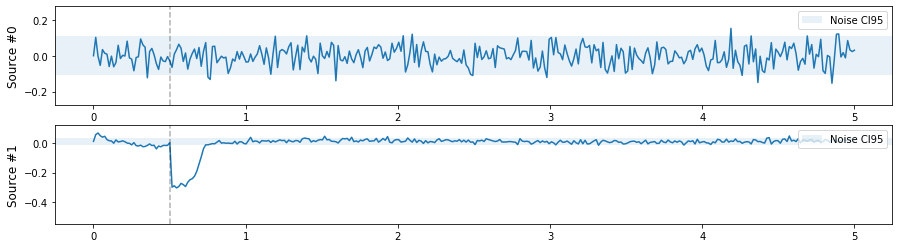

Enter one or more sources number (separate numbers by "," if number of sources > 1): 1


In [165]:
transitory = True
t_sig_onset = 0.5
t_sig_end = 0.8
n_comp = 2
method = 'wICA'
wavelet = 'dmey'
autoselect = 'manual'

stack_ROIs_AP, label_ROIs_AP, ROIs_means_filtered_AP_optimized2, time_AP, \
ROIs_means_AP, ROIs_means_corrected_AP, \
mask_list_AP, components_AP, selected_source_idx_AP, \
t_sig_prop_AP, SNR_dB_AP = metroid.metroid(path, fr, transitory,16,16, t_sig_onset,t_sig_end,method,n_comp,wavelet,autoselect)

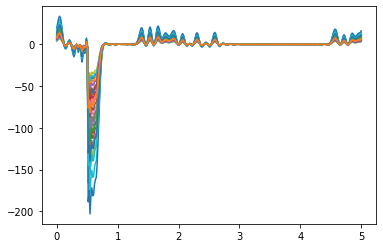

In [166]:
plt.plot(time_AP,ROIs_means_filtered_AP_optimized2)

In [167]:
ROIs_masks_artificial, label_ROIs_artificial, ROIs_means_artificial1, time_artificial   = mes.segment(cell_mask, artificial_video, fs)

(array([-140., -120., -100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,
          40.]), <a list of 10 Text yticklabel objects>)

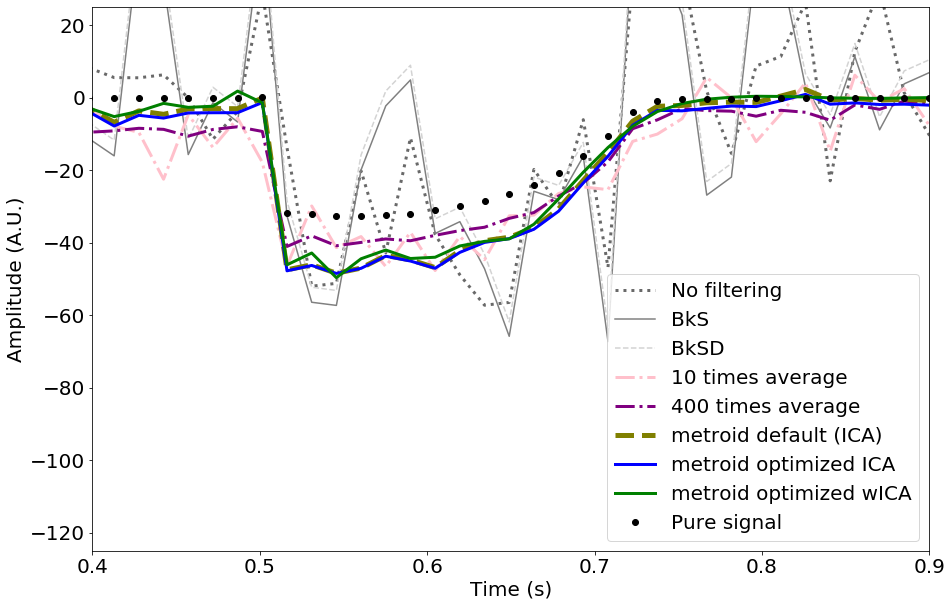

In [168]:
i = 1
plt.figure(figsize=[15,10])
plt.plot(time_AP,ROIs_means_artificial1[:,i] - np.median(np.concatenate((ROIs_means_artificial1[0:i0_5_sub],ROIs_means_artificial1[i0_8_sub:])),axis=0)[i],':',color='dimgray',label='No filtering',lw=3)
plt.plot(time_AP,BkS_no_offset[:,i],label='BkS',color='gray')
plt.plot(time_AP,BkSD_no_offset[:,i],'--',label='BkSD',color='lightgray')
plt.plot(time_AP,avg10_no_offset[:,i],'-.',label='10 times average',color='pink',lw=3)
plt.plot(time_AP,avgn_no_offset[:,i],'-.',label='400 times average',color='purple',lw=3)

plt.plot(time_AP,ROIs_means_filtered_AP_default[:,i],'--',label='metroid default (ICA)',lw=5,color='olive')
plt.plot(time_AP,ROIs_means_filtered_AP_optimized[:,i],'b-',label='metroid optimized ICA',lw=3)
plt.plot(time_AP,ROIs_means_filtered_AP_optimized2[:,i],color='green',label='metroid optimized wICA',lw=3)
plt.plot(time_AP,ROIs_means_signal2[:,i],'ko',label='Pure signal')
plt.legend(fontsize=20)
plt.axis([0.4,0.9,-125,25])
plt.xlabel('Time (s)',size=20)
plt.ylabel('Amplitude (A.U.)',size=20)
plt.xticks(size=20)
plt.yticks(size=20)

# Performance outputs

### Relative Max Amplitude Error

In [169]:
metroid_optimized2_meanbaseline = np.median(np.concatenate((ROIs_means_filtered_AP_optimized2[0:i0_5_sub],ROIs_means_filtered_AP_optimized2[i0_8_sub:])),axis=0)
print(metroid_optimized2_meanbaseline)
metroid_optimized2_no_offset = ROIs_means_filtered_AP_optimized2 - metroid_optimized2_meanbaseline

[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
 -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]


In [170]:
metroid_optimized2_max_values = -(ROIs_means_filtered_AP_optimized2[max_idx_sub] - metroid_optimized2_meanbaseline)
print(metroid_optimized2_max_values)

[ 41.18  44.41  69.41  91.95 134.91 112.84  84.54  60.22  35.19  39.11
  57.89  68.4   91.9  106.28  98.11  78.91  49.47  92.44 133.59 159.59
 181.72 122.35 104.89  64.36  48.83  55.25  69.25 121.82 135.56 140.05
 125.17  73.34]


In [171]:
Rel_error_metroid_optimized2 = ((metroid_optimized2_max_values-true_max_values)/true_max_values)*100 
print(Rel_error_metroid_optimized2)

[ 21.47  36.44  23.85  -1.84  -1.01  -6.06  -3.29  21.43  31.81  64.78
  51.53   5.13   0.46  -0.08   3.42  29.85  -1.47   8.14  -1.27  -3.62
   9.93  -7.78   8.1    3.53  36.39   0.62 -12.1   10.9    3.98  -3.13
  -2.9   -7.32]


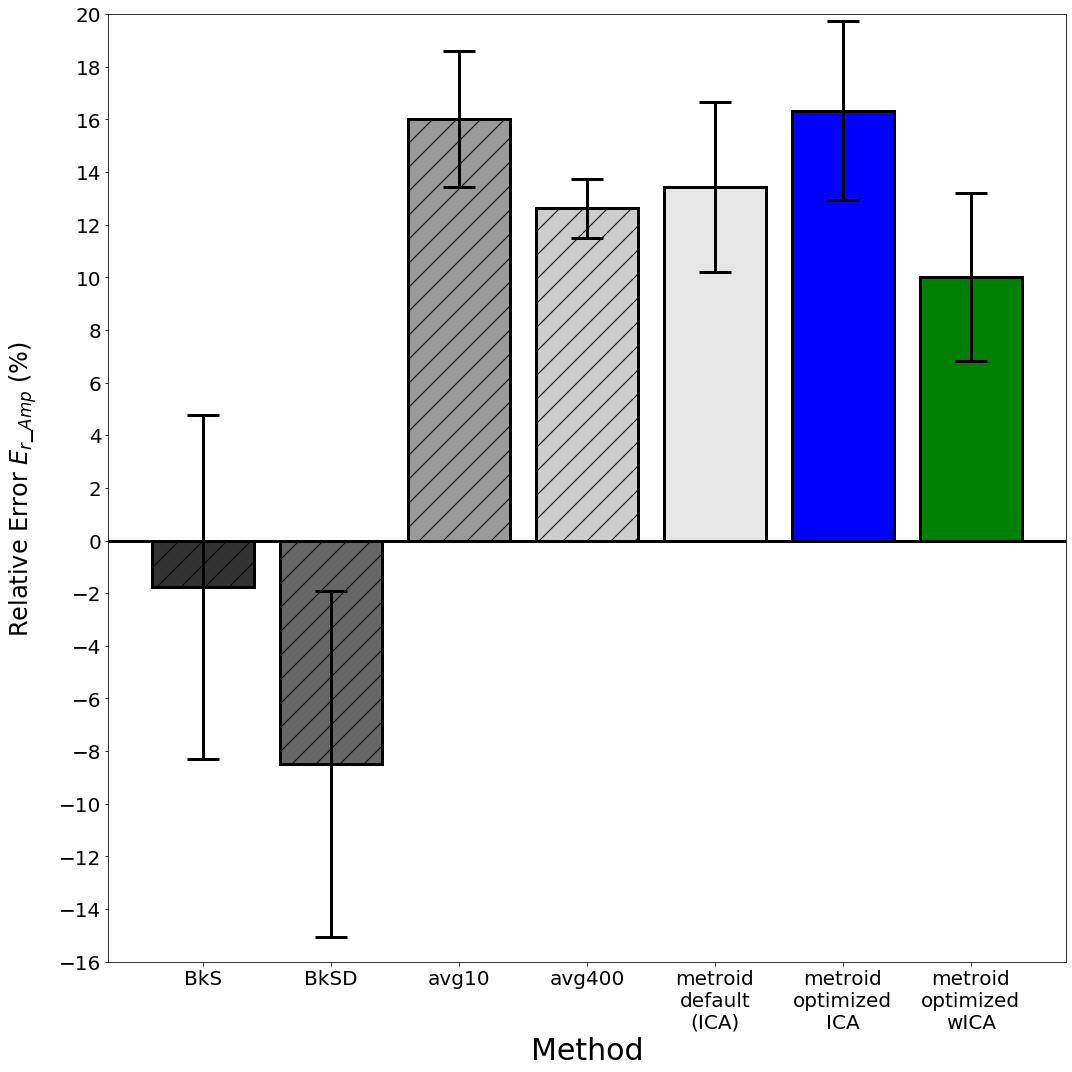

In [172]:
fig, ax = plt.subplots(figsize=[15,15])

graylvl=0.2
ax.bar(['BkS'],np.mean(Rel_error_BkS),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['BkS'],np.mean(Rel_error_BkS),np.std(Rel_error_BkS)/np.sqrt(len(Rel_error_BkS)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.4
ax.bar(['BkSD'],np.mean(Rel_error_BkSD),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['BkSD'],np.mean(Rel_error_BkSD),np.std(Rel_error_BkSD)/np.sqrt(len(Rel_error_BkSD)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.6
ax.bar(['avg10'],np.mean(Rel_error_avg10),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['avg10'],np.mean(Rel_error_avg10),np.std(Rel_error_avg10)/np.sqrt(len(Rel_error_avg10)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.8
ax.bar(['avg400'],np.mean(Rel_error_avgn),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['avg400'],np.mean(Rel_error_avgn),np.std(Rel_error_avgn)/np.sqrt(len(Rel_error_avgn)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.9
ax.bar(['metroid\ndefault\n(ICA)'],np.mean(Rel_error_metroid_default),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3)
ax.errorbar(['metroid\ndefault\n(ICA)'],np.mean(Rel_error_metroid_default),np.std(Rel_error_metroid_default)/np.sqrt(len(Rel_error_metroid_default)),capsize=16,color='k',lw=3,capthick=3)

ax.bar(['metroid\noptimized\nICA'],np.mean(Rel_error_metroid_optimized),color='b',edgecolor='k',lw=3)
ax.errorbar(['metroid\noptimized\nICA'],np.mean(Rel_error_metroid_optimized),np.std(Rel_error_metroid_optimized)/np.sqrt(len(Rel_error_metroid_optimized)),capsize=16,color='k',lw=3,capthick=3)

ax.bar(['metroid\noptimized\nwICA'],np.mean(Rel_error_metroid_optimized2),color='green',edgecolor='k',lw=3)
ax.errorbar(['metroid\noptimized\nwICA'],np.mean(Rel_error_metroid_optimized2),np.std(Rel_error_metroid_optimized2)/np.sqrt(len(Rel_error_metroid_optimized2)),capsize=16,color='k',lw=3,capthick=3)

ax.set_yticks(np.arange(-20,22,2))
ax.set_ylim(-16, 20)  # outliers only

# Axes labels
s = 'Relative Error '+r'$E_r\__{Amp}$'+' (%)'
plt.ylabel(s,labelpad=20,size=24)
ax.set_xlabel('Method',size=30)

ax.tick_params('y',labelsize=20) #adjust yticks fontsize
ax.tick_params('x',labelsize=20)

plt.tight_layout()
ax.axhline(0,lw=3,color='k')

### Pearson Correlation Coefficient

In [173]:
corr_metroid_optimized2 = np.zeros((nregions,))
for i in range(nregions):
    matrix = np.corrcoef(signal_sub[i0_5_sub-1:i0_8_sub],ROIs_means_filtered_AP_optimized2[i0_5_sub-1:i0_8_sub,i],rowvar=False)
    corr_metroid_optimized2[i] = abs(matrix[0,1])
print(corr_metroid_optimized2)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


Text(0.5, 0, 'Method')

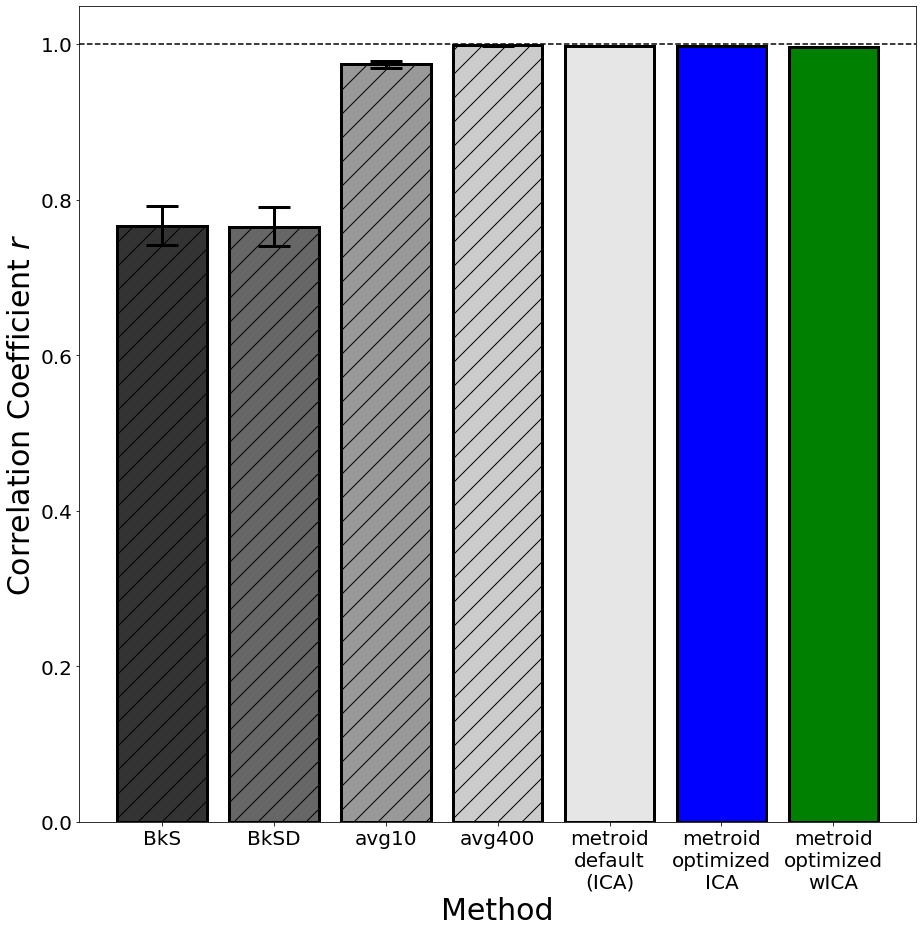

In [174]:
fig, ax = plt.subplots(figsize=[15,15],nrows=1, ncols=1)
graylvl=0.2
ax.bar(['BkS'],np.mean(corrBks),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['BkS'],np.mean(corrBks),np.std(corrBks)/np.sqrt(len(corrBks)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.4
ax.bar(['BkSD'],np.mean(corrBksD),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['BkSD'],np.mean(corrBksD),np.std(corrBksD)/np.sqrt(len(corrBksD)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.6
ax.bar(['avg10'],np.mean(corr_avg10),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['avg10'],np.mean(corr_avg10),np.std(corr_avg10)/np.sqrt(len(corr_avg10)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.8
ax.bar(['avg400'],np.mean(corr_avgn),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['avg400'],np.mean(corr_avgn),np.std(corr_avgn)/np.sqrt(len(corr_avgn)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.9
ax.bar(['metroid\ndefault\n(ICA)'],np.mean(corr_metroid_default),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3)
ax.errorbar(['metroid\ndefault\n(ICA)'],np.mean(corr_metroid_default),np.std(corr_metroid_default)/np.sqrt(len(corr_metroid_default)),capsize=16,color='k',lw=3,capthick=3)

ax.bar(['metroid\noptimized\nICA'],np.mean(corr_metroid_optimized),color='b',edgecolor='k',lw=3)
ax.errorbar(['metroid\noptimized\nICA'],np.mean(corr_metroid_optimized),np.std(corr_metroid_optimized)/np.sqrt(len(corr_metroid_optimized)),capsize=16,color='k',lw=3,capthick=3)

ax.bar(['metroid\noptimized\nwICA'],np.mean(corr_metroid_optimized2),color='green',edgecolor='k',lw=3)
ax.errorbar(['metroid\noptimized\nwICA'],np.mean(corr_metroid_optimized2),np.std(corr_metroid_optimized2)/np.sqrt(len(corr_metroid_optimized2)),capsize=16,color='k',lw=3,capthick=3)

plt.axhline(1,ls='--',color='k')

ax.tick_params('y',labelsize=20) #adjust yticks fontsize
ax.tick_params('x',labelsize=20) #adjust xticks fontsize
s = 'Correlation Coefficient '+r'$r$'
ax.set_ylabel(s,size=30)
ax.set_xlabel('Method',size=30)

### RMSE (Root-Mean-Squared Error)

In [175]:
RMSE_metroid_optimized2 = (np.sqrt(np.sum((metroid_optimized2_no_offset - ROIs_means_signal2)**2,axis=0)/n_samples))
print(RMSE_metroid_optimized2)

[2.3  2.97 4.   4.   5.88 4.98 3.68 3.36 2.24 3.32 4.46 3.1  4.02 4.64
 4.38 4.9  2.15 4.33 5.82 6.95 8.7  5.48 4.91 2.87 3.26 2.42 3.31 5.9
 6.08 6.1  5.45 3.27]


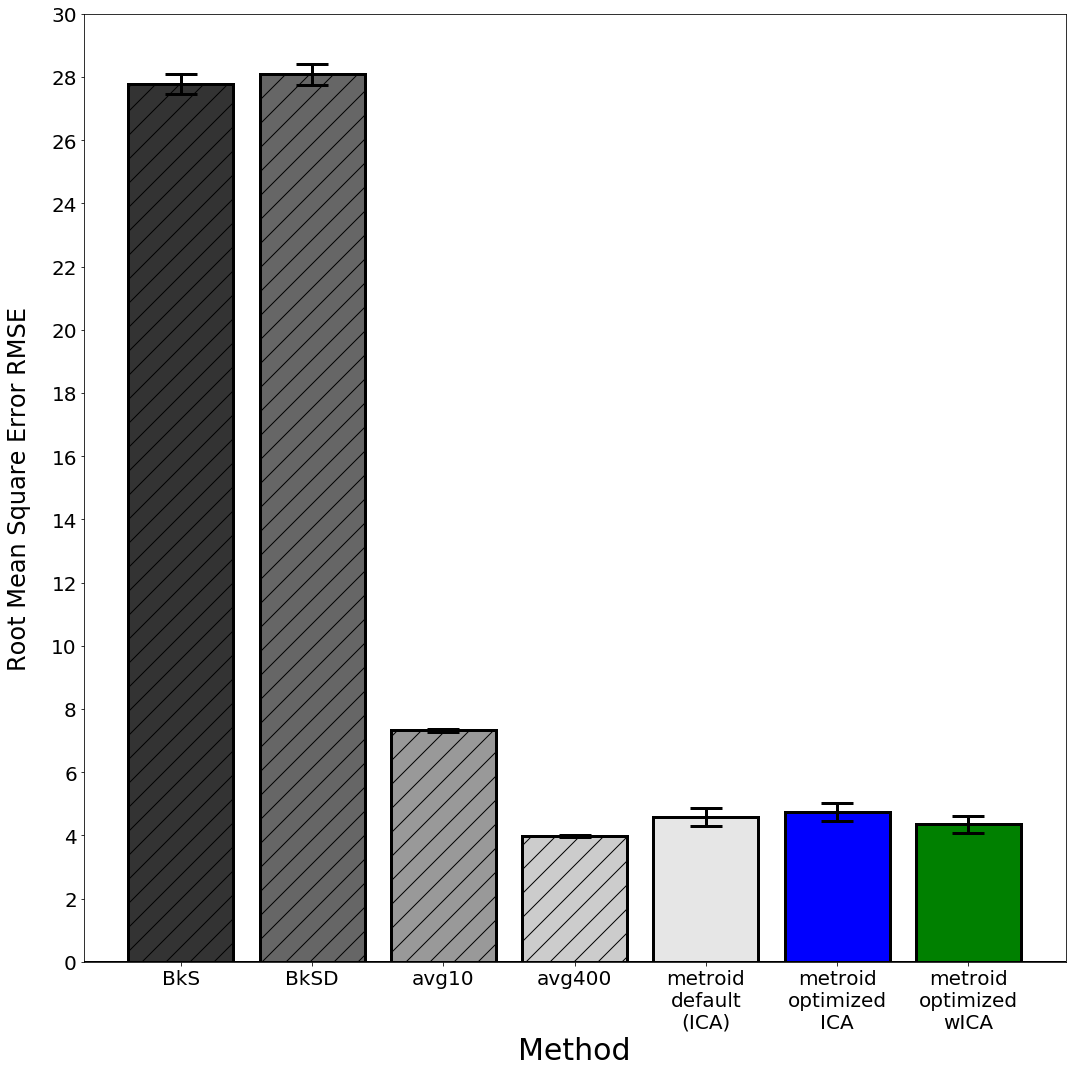

In [178]:
fig, ax = plt.subplots(figsize=[15,15])

graylvl=0.2
ax.bar(['BkS'],np.mean(RMSE_BkS),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['BkS'],np.mean(RMSE_BkS),np.std(RMSE_BkS)/np.sqrt(len(RMSE_BkS)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.4
ax.bar(['BkSD'],np.mean(RMSE_BkSD),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['BkSD'],np.mean(RMSE_BkSD),np.std(RMSE_BkSD)/np.sqrt(len(RMSE_BkSD)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.6
ax.bar(['avg10'],np.mean(RMSE_avg10),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['avg10'],np.mean(RMSE_avg10),np.std(RMSE_avg10)/np.sqrt(len(RMSE_avg10)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.8
ax.bar(['avg400'],np.mean(RMSE_avgn),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3,hatch='/')
ax.errorbar(['avg400'],np.mean(RMSE_avgn),np.std(RMSE_avgn)/np.sqrt(len(RMSE_avgn)),capsize=16,color='k',lw=3,capthick=3)

graylvl=0.9
ax.bar(['metroid\ndefault\n(ICA)'],np.mean(RMSE_metroid_default),color=((graylvl,graylvl,graylvl)),edgecolor='k',lw=3)
ax.errorbar(['metroid\ndefault\n(ICA)'],np.mean(RMSE_metroid_default),np.std(RMSE_metroid_default)/np.sqrt(len(RMSE_metroid_default)),capsize=16,color='k',lw=3,capthick=3)

ax.bar(['metroid\noptimized\nICA'],np.mean(RMSE_metroid_optimized),color='b',edgecolor='k',lw=3)
ax.errorbar(['metroid\noptimized\nICA'],np.mean(RMSE_metroid_optimized),np.std(RMSE_metroid_optimized)/np.sqrt(len(RMSE_metroid_optimized)),capsize=16,color='k',lw=3,capthick=3)

ax.bar(['metroid\noptimized\nwICA'],np.mean(RMSE_metroid_optimized2),color='green',edgecolor='k',lw=3)
ax.errorbar(['metroid\noptimized\nwICA'],np.mean(RMSE_metroid_optimized2),np.std(RMSE_metroid_optimized2)/np.sqrt(len(RMSE_metroid_optimized2)),capsize=16,color='k',lw=3,capthick=3)

ax.set_yticks(np.arange(0,32,2))
ax.set_ylim(0, 30)  # most of the data

# Axes labels
s = 'Root Mean Square Error RMSE'
plt.ylabel(s,labelpad=20,size=24)
ax.set_xlabel('Method',size=30)

ax.tick_params('y',labelsize=20) #adjust yticks fontsize
ax.tick_params('x',labelsize=20)
plt.tight_layout()
ax.axhline(0,lw=3,color='k')

In [177]:
fobj = open("./AP_Cell1.txt",mode="w")
fobj.write("AP_Rel_Err\tAP_corr\tAP_RMSE\n\n")
matrix = np.ravel(Rel_error_BkS).reshape(1,len(Rel_error_BkS))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(Rel_error_BkSD).reshape(1,len(Rel_error_BkSD))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(Rel_error_avg10).reshape(1,len(Rel_error_avg10))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(Rel_error_avgn).reshape(1,len(Rel_error_avgn))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(Rel_error_metroid_default).reshape(1,len(Rel_error_metroid_default))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(Rel_error_metroid_optimized).reshape(1,len(Rel_error_metroid_optimized))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(Rel_error_metroid_optimized2).reshape(1,len(Rel_error_metroid_optimized2))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

fobj.write("\n")

matrix = np.ravel(corrBks).reshape(1,len(corrBks))
np.savetxt(fobj, matrix,fmt='%.3f', delimiter='\t', newline='\n')

matrix = np.ravel(corrBksD).reshape(1,len(corrBksD))
np.savetxt(fobj, matrix,fmt='%.3f', delimiter='\t', newline='\n')

matrix = np.ravel(corr_avg10).reshape(1,len(corr_avg10))
np.savetxt(fobj, matrix,fmt='%.3f', delimiter='\t', newline='\n')

matrix = np.ravel(corr_avgn).reshape(1,len(corr_avgn))
np.savetxt(fobj, matrix,fmt='%.3f', delimiter='\t', newline='\n')

matrix = np.ravel(corr_metroid_default).reshape(1,len(corr_metroid_default))
np.savetxt(fobj, matrix,fmt='%.3f', delimiter='\t', newline='\n')

matrix = np.ravel(corr_metroid_optimized).reshape(1,len(corr_metroid_optimized))
np.savetxt(fobj, matrix,fmt='%.3f', delimiter='\t', newline='\n')

matrix = np.ravel(corr_metroid_optimized2).reshape(1,len(corr_metroid_optimized2))
np.savetxt(fobj, matrix,fmt='%.3f', delimiter='\t', newline='\n')

fobj.write("\n")

matrix = np.ravel(RMSE_BkS).reshape(1,len(RMSE_BkS))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(RMSE_BkSD).reshape(1,len(RMSE_BkSD))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(RMSE_avg10).reshape(1,len(RMSE_avg10))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(RMSE_avgn).reshape(1,len(RMSE_avgn))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(RMSE_metroid_default).reshape(1,len(RMSE_metroid_default))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(RMSE_metroid_optimized).reshape(1,len(RMSE_metroid_optimized))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')

matrix = np.ravel(RMSE_metroid_optimized2).reshape(1,len(RMSE_metroid_optimized2))
np.savetxt(fobj, matrix,fmt='%.2f', delimiter='\t', newline='\n')


fobj.close()